In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import glob
import time 
from statsmodels.graphics.tsaplots import acf
from scipy.signal import periodogram
from scipy.spatial import distance
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import datetime
from scipy.interpolate import interp1d


In [2]:
pd.set_option('display.max_row', 1000)

# Get data

## 1 minutely data

In [166]:
path = "/Users/calumthompson/Documents/Final year project/Data/S&P500 1mins/*"   #put folder data is in here

data_merge = []

for fname in glob.glob(path):
    x = pd.read_csv(fname, dtype = {'<TIME>': str})
    
    data_merge.append(x)

SandP_1mins = pd.concat(data_merge)

SandP_1mins.columns = SandP_1mins.columns.str.replace("<","").str.replace(">","")

SandP_1mins['TIMESTAMP'] = SandP_1mins['DATE'].astype(str) + SandP_1mins['TIME'].astype(str)
SandP_1mins['TIMESTAMP'] = pd.to_datetime(SandP_1mins['TIMESTAMP'] ,format='%Y%m%d%H%M%S')
SandP_1mins['DATE'] = pd.to_datetime(SandP_1mins['DATE'] ,format='%Y%m%d')

SandP_1mins = SandP_1mins[['DATE','TIMESTAMP','TIME','OPEN','HIGH','LOW','CLOSE','VOL']]
SandP_1mins = SandP_1mins.sort_values('TIMESTAMP')

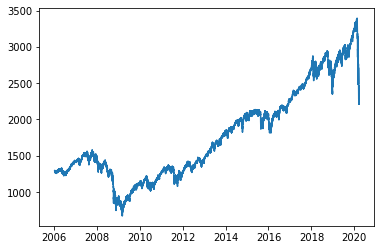

In [168]:
plt.plot(SandP_1mins['DATE'], SandP_1mins['CLOSE'])
plt.show();

## Fractional change to close value

In [8]:
close_prices = pd.DataFrame(SandP_5mins.groupby('DATE')['OPEN'].last()).reset_index()
close_prices['Change %'] = (close_prices['OPEN'].diff()/ close_prices['OPEN']) *100

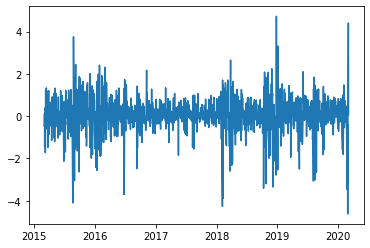

In [9]:
plt.plot(close_prices['DATE'], close_prices['Change %'])

# Functions

## Find lag $J$


In [10]:
def compute_lag(data, plot = False):

    autocorr = acf(data, fft = True, nlags = 500)

    if (plot):
        plt.plot(autocorr)
        plt.axhline(1 - 1/np.e, linestyle = "--", c = 'k', label = '1-1/e')
        plt.legend(loc = 'best')
        
    i = 0
        
    while (autocorr[i] > (1-1/np.e)):
        lag = autocorr[i]
        i += 1
        
    if (plot):
        plt.axvline(i)

    return i

## Calculate mean period $\mu$

In [11]:
def compute_mean_period (timeseries):
    power_spectrum = periodogram(timeseries)[1]
    frequencies = periodogram(timeseries)[0]
    
    weights = power_spectrum / sum(power_spectrum)
    return 1/np.average(frequencies, weights = weights)

## Encode into phase space

In [12]:
def gen_phase_space_matrix(timeseries, J, m):
    
    timeseries = timeseries.to_list()
    
    matrix = pd.DataFrame(columns = np.arange(0,m))
        
    for i, val in enumerate(timeseries):
        
        x_i = []

        for it in range(0, m):
            
            try:
                i_plus_j = timeseries[i + J*it]
                x_i.append(i_plus_j)
            except:
                x_i.append(np.nan)
                
        
        matrix.loc[i] = x_i
    return matrix

## Find initial nearest neighbours

In [15]:
def euc_distance (p1, p2):
    
    try: 
        return distance.euclidean (p1,p2)
    except:
        return np.inf

In [16]:
def find_nearest_neighbour (dataframe, ref_index, mean_period, i_max = 25,print_error = False):
    
    start = datetime.datetime.now()
    
    dists = []
    ref_row = dataframe.iloc[ref_index, :].values

    min_dist = np.inf 
    min_index = np.nan

    for i in range(0,dataframe.shape[0] - i_max):

        test_row = dataframe.iloc[i, :].values

        if i != ref_index and abs(i-ref_index) > mean_period and euc_distance(ref_row, test_row) > 0:

            dist = euc_distance(ref_row, test_row)

            if dist  < min_dist:
                min_dist = dist
                min_index = i


    if min_dist == np.inf and print_error:
            print('Nearest neighbour not found for index ', ref_index)
            
    end = datetime.datetime.now()
        
    return min_index

## Compute divergence


In [22]:
def compute_divergence(dataframe, NN_pairs, i_max = 25): 
    
    dj_data = []
    
    for i in range (0,i_max): # calculate divergence through i_max steps
        
        dj_i = []
    
        for k in range (0,(dataframe.shape[0] - i_max)): # compute for all nearest neighbour pairs 
            
            if (np.nan not in NN_pairs[k]):
                NN_1 = NN_pairs[k][0]
                NN_2 = NN_pairs[k][1]

                p1 = dataframe.iloc[NN_1 + i, :] #go to matrix and find row #NN_1 + i
                p2 = dataframe.iloc[NN_2 + i, :]

                if euc_distance(p1,p2) > 0: 
                    dj_i.append(euc_distance(p1,p2))
                
        
        dj_data.append([i,np.mean(np.log(dj_i))])
        

    return dj_data

# New fit

## Find gradient - last years method

### Forward difference approximation

$$y'(t0) = (y1-y0) / (x1 - x0)$$

In [ ]:
def forward_difference_approximation(x, y):
    
    diff_funct = []
    
    for it in range(0, len(x) - 1):
        
        y1_y0 = y[it+1] - y[it] 
        x1_x0 = x[it+1] - x[it] 
        
        diff_funct.append(y1_y0/x1_x0)
    
    return  pd.DataFrame(diff_funct,x[0:len(x) -1], columns = ['y'])

### Last years linearity score

$$L = (N_{lin})^a + <ln(d')>^b$$

where $N_{lin}$ is the number of points within the concerned region, and $<ln(d')>$ is the mean gradient of the concerned region. The region with the highest was deemed to be the FLE region. The value of parameter b was chosen to be 2, so that linear regions with negative gradients could be identified.

a = 2.1

In [ ]:
# def score_linearity(start, end, divergence, divergence_prime, a = 1, b = 5):
#     region = divergence.loc[start + 0.1:end]
#     region_grad = divergence_prime[start + 0.1: end]
    
#     N = region.shape[0]
#     mean_grad = region_grad['y'].mean()
        
#     return (N**a) + (mean_grad**b) , N**a, mean_grad**b

### That didnt work. Lets try:

$$L = a(N_{lin}) + b<ln(d')>$$

where $N_{lin}$ is the number of points within the concerned region, and $<ln(d')>$ is the mean gradient of the concerned region. The region with the highest was deemed to be the FLE region. 

In [ ]:
def score_linearity(start, end, divergence, divergence_prime, a = 0.1, b = 5):
    region = divergence.loc[start + 0.1:end]
    region_grad = divergence_prime[start + 0.1: end]
    
    N = region.shape[0]
    mean_grad = region_grad['y'].mean()
        
    return (N*a) + (mean_grad*b) , N*a, mean_grad*b

### Fit linear region

In [ ]:
def fit_linear_region(divergence, delta_t,plot_fit = False, plot_derivatives = False, print_linearity_scores = False):

    # Add interpolation points
    f = interp1d(divergence['i'], divergence['log(dj)'])
    i_new = np.arange(0,max(divergence['i']),0.1)
    div_interpolated = pd.DataFrame(f(i_new),i_new,columns = ['y'])


    #get derivative and 2nd derivative
    d_prime = forward_difference_approximation(div_interpolated.index.values , div_interpolated['y'].values)
    d_dprime= forward_difference_approximation(d_prime.index.values , d_prime['y'].values)
    stdev = np.std(d_dprime['y'])

    # identify regions where d'' > 1 std
    out_of_bounds = d_dprime.loc[np.abs(d_dprime['y']) > std]

    out_of_bounds.loc[0] = 0
    out_of_bounds.loc[i_max] = 0
    out_of_bounds = out_of_bounds.sort_index()

    # assign linearity scores
    linearity_scores = []

    for i in range(0,out_of_bounds.shape[0] - 1):
        start = out_of_bounds.iloc[i].name
        end = out_of_bounds.iloc[i + 1].name

        score, NtoB, gradtoA = score_linearity(start,end,divergence,d_prime )
        linearity_scores.append([start,end,score, NtoB, gradtoA])

    linearity_scores = pd.DataFrame(linearity_scores, columns = ['start','end','score','N^a','grad^b'])  
    
    if print_linearity_scores:
        print(linearity_scores)

    linearity_scores = linearity_scores.sort_values(by = 'score', ascending= False)
    top_score = linearity_scores.head(1)

    fit_data = div_interpolated.loc[top_score['start'].values[0]: top_score['end'].values[0]]

    fit_region_y = fit_data['y'].values.reshape(-1,1)
    fit_region_x = fit_data.index.values.reshape(-1,1)

    regressor = LinearRegression() 
    regressor.fit(fit_region_x,fit_region_y)
    fit = regressor.predict(fit_region_x) 

    slope = regressor.coef_[0][0]

    r_squared = metrics.r2_score(fit_region_y,fit)

    lyapunov_exponent = slope * delta_t
    error = metrics.mean_absolute_error(fit_region_y, fit) * delta_t

    if plot_fit:
    # raw input

        plt.plot(div_interpolated)
        plt.title('$\lambda_{1}$ = ' + '{:.4f}'.format(slope) + '+/-' '{:.4f}'.format(error))
        plt.xlabel('i')
        plt.ylabel('$d_{j}}$')
        plt.plot(fit_region_x, fit, c = 'k')
       # plt.axhline(0, c = '0.25')

        for i in range(0,linearity_scores.shape[0] -1 ):
            start = linearity_scores.iloc[i]['start'] + 0.1
            end = linearity_scores.iloc[i]['end'] - 0.1
            plt.axvspan(start,end, color='red', alpha=0.35)
        plt.show();

    if plot_derivatives:    
    # derivative
        plt.plot(d_prime)
        plt.title('First derivative')
        plt.xlabel('i')
        plt.axhline(0, c = '0.25')
        plt.show();

    # second derivative
        print("Standard deviation = ",stdev)

        plt.plot(d_dprime)
        plt.title('Second derivative')
        plt.axhline(stdev, c = 'k', linestyle = ':')
        plt.axhline(-stdev, c = 'k', linestyle = ':')
        plt.axhline(0, c = '0.25')
        plt.xlabel('i')


        plt.plot(out_of_bounds, c = 'r', label = 'points out of bounds', linestyle = 'None', marker = 'o')
        plt.legend()
        plt.show();
        
    return lyapunov_exponent, error 

## Apply to data series

Lyapunov exponent $\lambda _{1}$ can be found from the following equation

$$ ln(d_{j}(i)) = \lambda _{1}i\Delta t + ln(d_{j}(0)) $$

In [ ]:
def calc_daily_lyapunov_exponent(dataframe, date, column = "OPEN", i_max = 25, plot_fit = False, plot_derivatives = False, delta_t_unit = 'days', time = False, m = 2):
    
    timings = []
    timings.append(['start',datetime.datetime.now()])
        
    regressor = LinearRegression()  
    
    time_series = dataframe.loc[dataframe["DATE"] == date][column]
    
    
    ### compute constants    
    timings.append(['compute consts',datetime.datetime.now()])
        
    J = compute_lag(time_series, plot = False)
    mu = compute_mean_period(time_series)
    
    if delta_t_unit == 'mins':
        delta_t = 1
    elif delta_t_unit == 'hours':
        delta_t = 1/(60)
    elif delta_t_unit == 'days':
        delta_t = 1/(24*60)
    
    ### generate matrix
    timings.append(['gen matrix',datetime.datetime.now()])
    matrix = gen_phase_space_matrix(time_series, J, m)
    matrix = matrix.dropna() ## drop rows that are missing a phase space co-ord (due to lag taking past end of list)
        
    ### find nearest neighbour pairs
    NN_pairs = []

    timings.append(['compute nearest neighbours',datetime.datetime.now()])
        
        
    for i in range(0,matrix.shape[0]):
        NN = find_nearest_neighbour(matrix, ref_index= i, mean_period = mu, i_max = i_max)
        NN_pairs.append([i,NN])

        
    ### calculative divergence 

    timings.append(['calc divergence',datetime.datetime.now()])
    lyapunov_data = pd.DataFrame(compute_divergence(matrix, NN_pairs, i_max = i_max), columns = ['i','log(dj)'])
        
    #return lyapunov_data 
        
    ### fit to get lyapunov
    if time:
        timings.append(['fit',datetime.datetime.now()])
        
    lyapunov_exponent, error =  fit_linear_region(lyapunov_data,delta_t, plot_fit, plot_derivatives)

    timings.append(['end', datetime.datetime.now()])
    
    timings = pd.DataFrame(timings,columns = ['task', 'start time'])
    timings['duration (s)'] = np.abs(timings['start time'].diff(periods = -1).dt.total_seconds())
    total_time = timings['duration (s)'].sum()
    
    if time:
        print(timings)
        print("Total time to find lyapunov exponent = ",total_time)
        return lyapunov_exponent, error, timings, total_time
    else:
        return lyapunov_exponent, error, total_time


## Apply to multiple days


In [ ]:
def calculate_lyapunov_exponents(matrix, start_date, end_date, plot_fit = False, plot_derivatives = False, i_max = 25, delta_t_unit = 'days', m = 2):
   
    # Open file for records
    filename = str(start) + " to " + str(end) + "_m" + str(m) + ".csv"
    f = open(filename, 'w')
    f.write('DATE,lyapunov_exponent,error\n')
    
    # Load data to be computed
    sample = matrix.loc[(matrix['DATE'] >= start_date) & (matrix['DATE'] <= end_date)]

    dates = sample['DATE'].unique()
    
    results = []
    run_time = []
    start_time = datetime.datetime.now()
    cycle_count = 0
    
    # Print some stuff before beginning
    print("computing for ", len(dates), 'days')
    print("Start at ", start_time )
    print("")
    
    
    # Iterate through dates
    for date in dates:
        
        print_date = pd.to_datetime(date)
        print("")
        print(cycle_count + 1,") Computing ", print_date.strftime("%a %d %b %Y"), "... ", end ="")
        
        try:
            lyapunov_exponent, error, total_time = calc_daily_lyapunov_exponent(sample,date, i_max = i_max, plot_fit = plot_fit, plot_derivatives = plot_derivatives, delta_t_unit = delta_t_unit, m=m)

            results.append([date,lyapunov_exponent, error,total_time])
            run_time.append(total_time)

            print("computed in ", total_time, 's')

            expected_time = (len(dates) - cycle_count - 1) * np.mean(run_time)
            print("Expected time remaining = ", expected_time, "s")

            f.write(str(date)+ ',' + str(lyapunov_exponent) + ',' + str(error) + '\n')

        except KeyboardInterrupt:
            raise
        except:
            print("Error with record = ", print_date.strftime("%a %d %b %Y"))
            
        cycle_count+= 1
    
    end_time = datetime.datetime.now()

    print("computation time = ", (end_time-start_time).total_seconds())

    results = pd.DataFrame(results, columns = ['DATE','lyapunov_exponent', 'error', 'compute time'])
    
    f.close()
    
    return results
    

# Apply to data

# Test for a day

    start   end     score  N^a    grad^b
0     0.0   0.9  1.783430  0.0  1.783430
1     0.9   2.9  0.681421  0.2  0.481421
2     2.9   3.9  0.145387  0.0  0.145387
3     3.9   4.9  0.813108  0.1  0.713108
4     4.9   7.9  0.408677  0.3  0.108677
5     7.9   8.9  1.027942  0.1  0.927942
6     8.9   9.9 -0.372752  0.1 -0.472752
7     9.9  13.9  0.403532  0.4  0.003532
8    13.9  19.9  0.689337  0.6  0.089337
9    19.9  21.9 -0.124633  0.1 -0.224633
10   21.9  25.0  0.258466  0.2  0.058466


/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


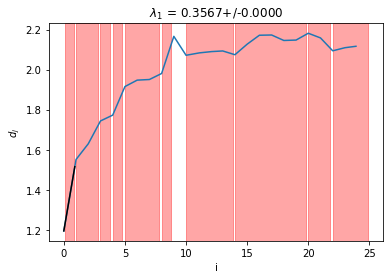

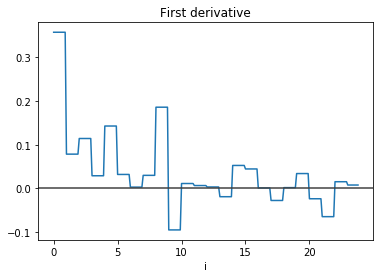

Standard deviation =  0.3225857081443535


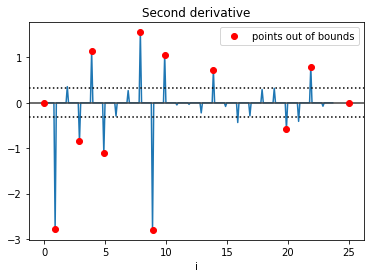

(0.0002476986534808483, 2.1587669923266932e-19, 23.477239)

In [422]:
calc_daily_lyapunov_exponent(SandP_1mins, '2019-02-07', plot_fit =True, plot_derivatives=True , i_max = 25, time = False, m = 2)



# Apply to a whole year - 2019

In [424]:
start = '2019-01-02'
end = '2020-01-02'

computing for  253 days
Start at  2020-03-30 17:39:58.081048


1 ) Computing  Wed 02 Jan 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


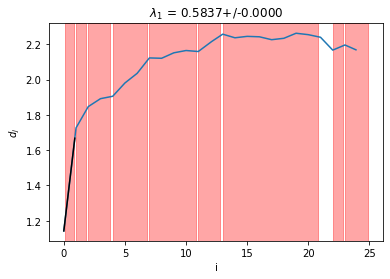

computed in  24.071721000000004 s
Expected time remaining =  6066.073692000001 s

2 ) Computing  Thu 03 Jan 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


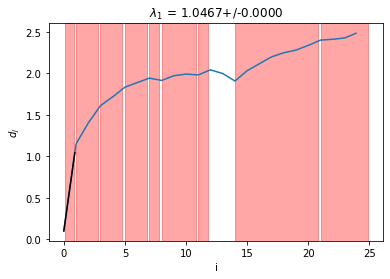

computed in  27.155641000000003 s
Expected time remaining =  6429.033931000001 s

3 ) Computing  Fri 04 Jan 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


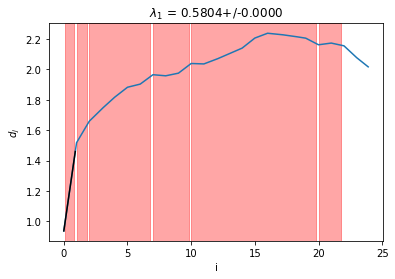

computed in  24.337035 s
Expected time remaining =  6297.033083333335 s

4 ) Computing  Mon 07 Jan 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


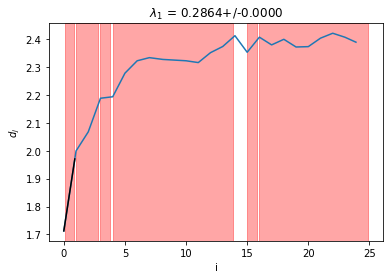

computed in  21.294055999999998 s
Expected time remaining =  6029.43869925 s

5 ) Computing  Tue 08 Jan 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


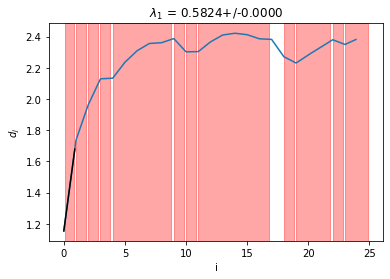

computed in  23.024150000000002 s
Expected time remaining =  5946.177108800001 s

6 ) Computing  Wed 09 Jan 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


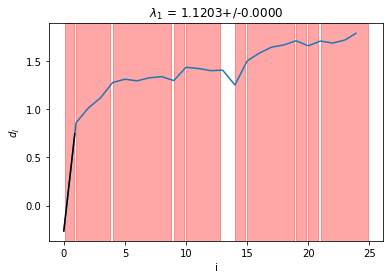

computed in  25.873171000000003 s
Expected time remaining =  6000.2793630000015 s

7 ) Computing  Thu 10 Jan 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


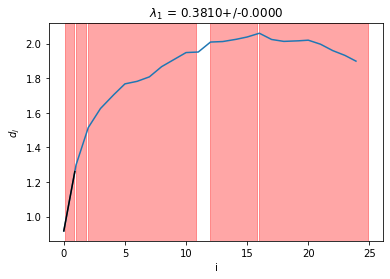

computed in  24.33098 s
Expected time remaining =  5977.334497714287 s

8 ) Computing  Fri 11 Jan 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


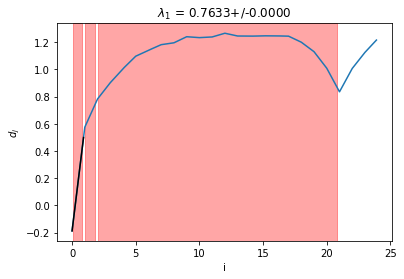

computed in  24.939361000000005 s
Expected time remaining =  5972.674771875 s

9 ) Computing  Mon 14 Jan 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


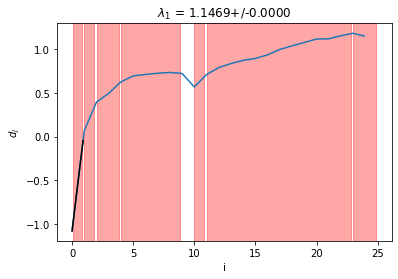

computed in  26.934327 s
Expected time remaining =  6017.594205333333 s

10 ) Computing  Tue 15 Jan 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


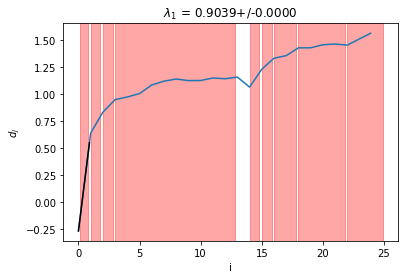

computed in  26.526133 s
Expected time remaining =  6038.2237725 s

11 ) Computing  Wed 16 Jan 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


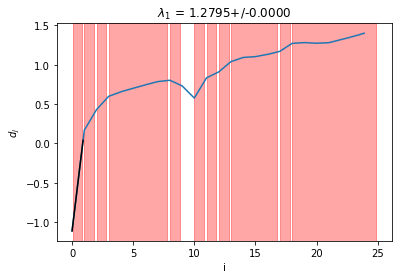

computed in  26.786772000000003 s
Expected time remaining =  6056.013634 s

12 ) Computing  Thu 17 Jan 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


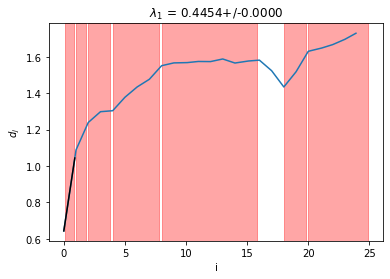

computed in  25.449244000000004 s
Expected time remaining =  6039.512035916667 s

13 ) Computing  Fri 18 Jan 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


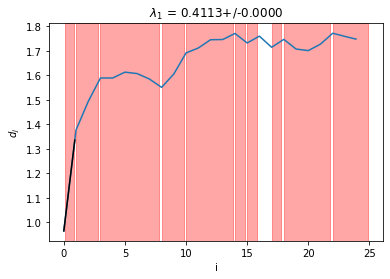

computed in  22.234889000000003 s
Expected time remaining =  5962.291938461539 s

14 ) Computing  Tue 22 Jan 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


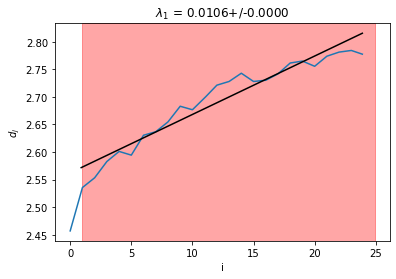

computed in  20.126257000000003 s
Expected time remaining =  5856.929510214287 s

15 ) Computing  Wed 23 Jan 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


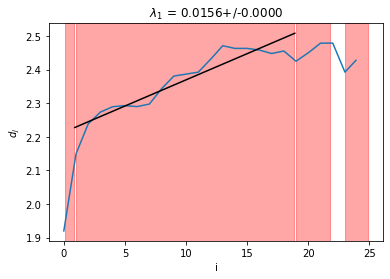

computed in  20.853106 s
Expected time remaining =  5774.464575600002 s

16 ) Computing  Thu 24 Jan 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


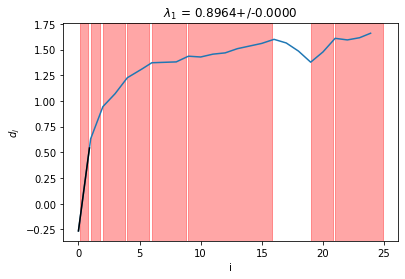

computed in  24.919027000000003 s
Expected time remaining =  5759.927574375 s

17 ) Computing  Fri 25 Jan 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


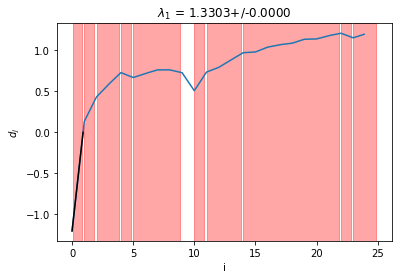

computed in  26.800037 s
Expected time remaining =  5770.282003058824 s

18 ) Computing  Mon 28 Jan 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


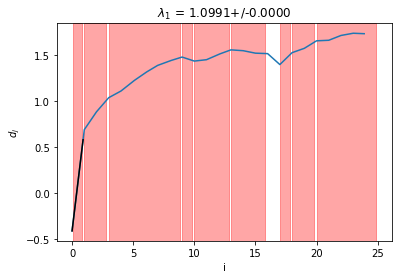

computed in  25.334157 s
Expected time remaining =  5757.37028 s

19 ) Computing  Tue 29 Jan 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


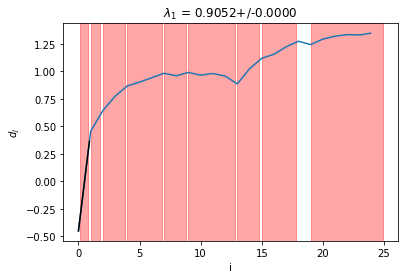

computed in  25.929761000000003 s
Expected time remaining =  5750.486265789474 s

20 ) Computing  Wed 30 Jan 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


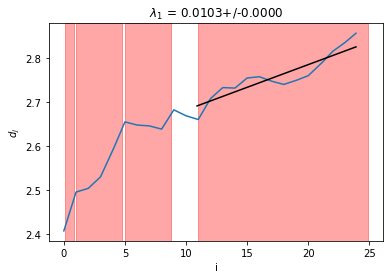

computed in  20.873496000000003 s
Expected time remaining =  5682.79218965 s

21 ) Computing  Thu 31 Jan 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


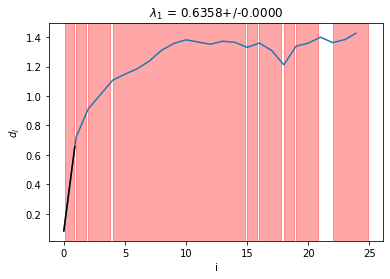

computed in  26.089296 s
Expected time remaining =  5677.179387809524 s

22 ) Computing  Fri 01 Feb 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


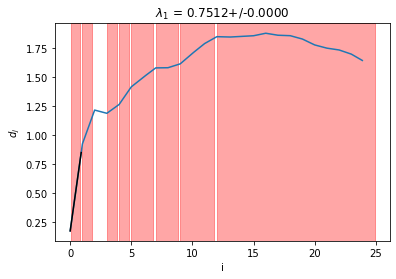

computed in  24.136113 s
Expected time remaining =  5649.1966649999995 s

23 ) Computing  Mon 04 Feb 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


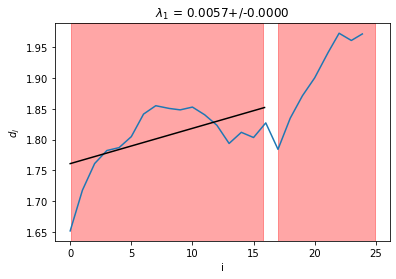

computed in  21.121429 s
Expected time remaining =  5591.40159 s

24 ) Computing  Tue 05 Feb 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


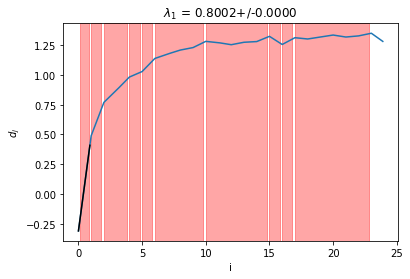

computed in  23.971915000000003 s
Expected time remaining =  5563.861039416668 s

25 ) Computing  Wed 06 Feb 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


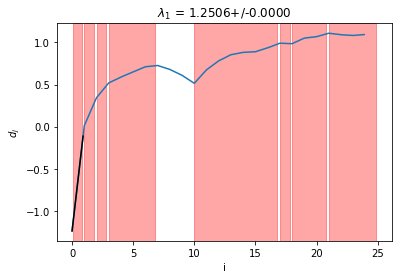

computed in  27.189496000000002 s
Expected time remaining =  5565.950318400001 s

26 ) Computing  Thu 07 Feb 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


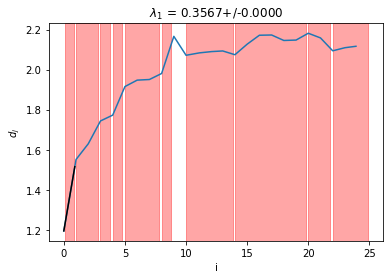

computed in  22.293522000000003 s
Expected time remaining =  5523.041764769232 s

27 ) Computing  Fri 08 Feb 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


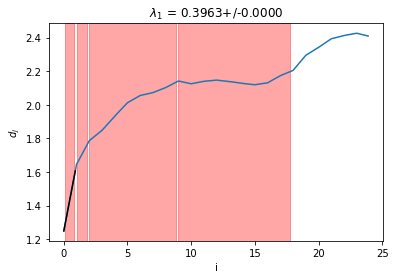

computed in  20.878971 s
Expected time remaining =  5469.819934740742 s

28 ) Computing  Mon 11 Feb 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


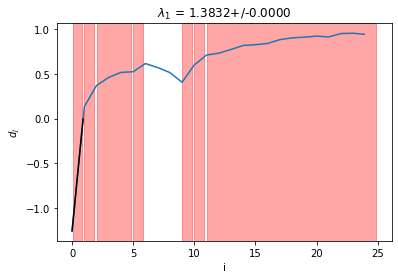

computed in  27.488742000000002 s
Expected time remaining =  5472.022540178573 s

29 ) Computing  Tue 12 Feb 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


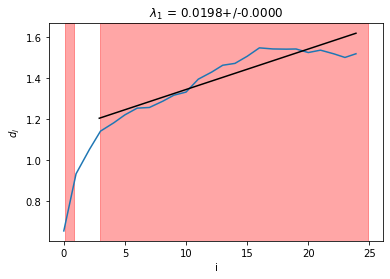

computed in  22.765276 s
Expected time remaining =  5435.692763586208 s

30 ) Computing  Wed 13 Feb 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


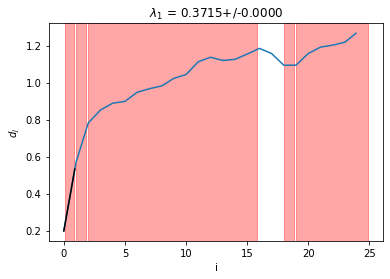

computed in  24.818922 s
Expected time remaining =  5415.532722300001 s

31 ) Computing  Thu 14 Feb 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


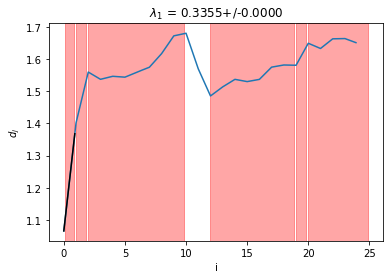

computed in  22.260603 s
Expected time remaining =  5376.751242967743 s

32 ) Computing  Fri 15 Feb 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


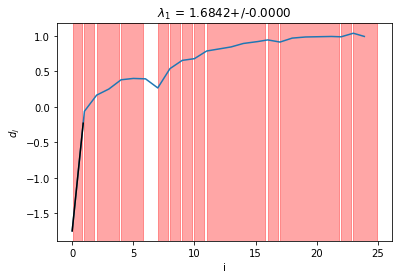

computed in  28.379627000000003 s
Expected time remaining =  5381.261827906251 s

33 ) Computing  Tue 19 Feb 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


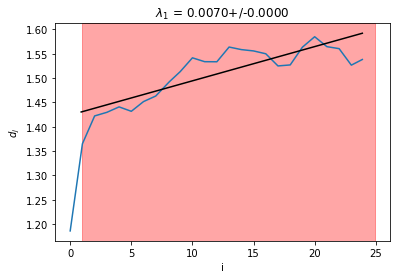

computed in  22.313854000000003 s
Expected time remaining =  5343.34058 s

34 ) Computing  Wed 20 Feb 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


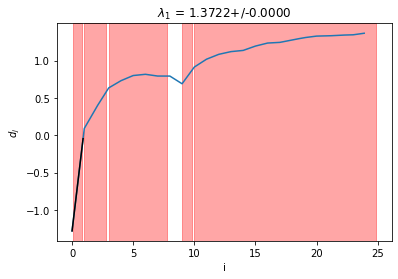

computed in  27.411289 s
Expected time remaining =  5339.170892470589 s

35 ) Computing  Thu 21 Feb 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


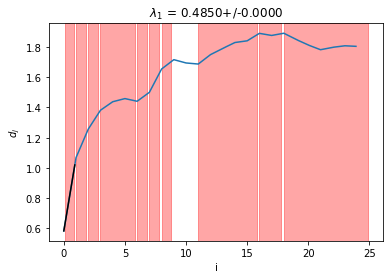

computed in  23.071811 s
Expected time remaining =  5306.644364742859 s

36 ) Computing  Fri 22 Feb 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


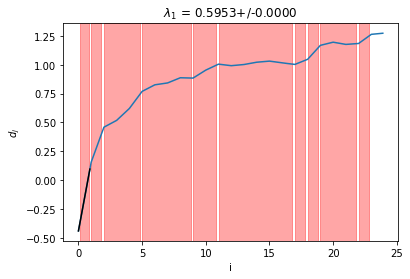

computed in  25.559482000000003 s
Expected time remaining =  5289.638227027778 s

37 ) Computing  Mon 25 Feb 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


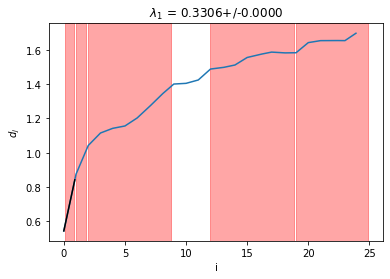

computed in  21.844441000000003 s
Expected time remaining =  5250.48193945946 s

38 ) Computing  Tue 26 Feb 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


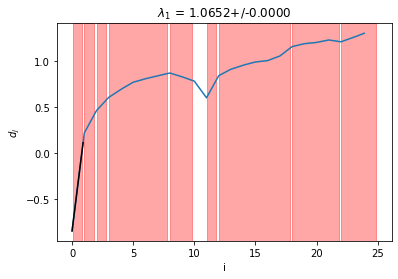

computed in  26.372634000000005 s
Expected time remaining =  5237.856841052632 s

39 ) Computing  Wed 27 Feb 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


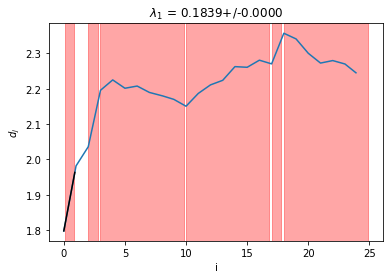

computed in  20.580318000000002 s
Expected time remaining =  5192.743263282053 s

40 ) Computing  Thu 28 Feb 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


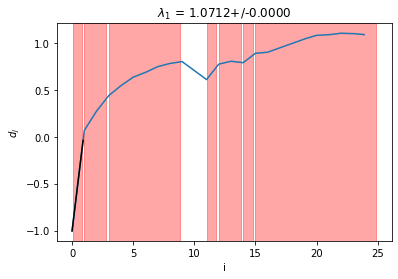

computed in  26.567216000000002 s
Expected time remaining =  5180.736580350001 s

41 ) Computing  Fri 01 Mar 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


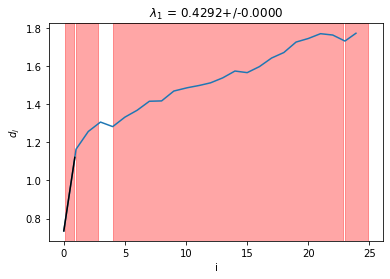

computed in  30.830930000000002 s
Expected time remaining =  5190.066148682928 s

42 ) Computing  Mon 04 Mar 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


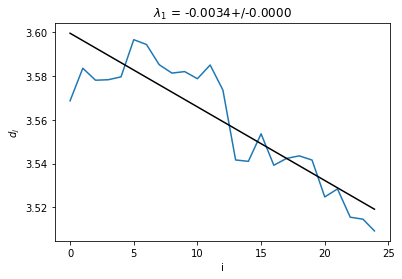

computed in  23.088329 s
Expected time remaining =  5158.585959690477 s

43 ) Computing  Tue 05 Mar 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


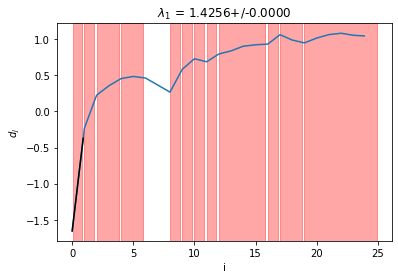

computed in  36.230146000000005 s
Expected time remaining =  5191.6770565116285 s

44 ) Computing  Wed 06 Mar 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


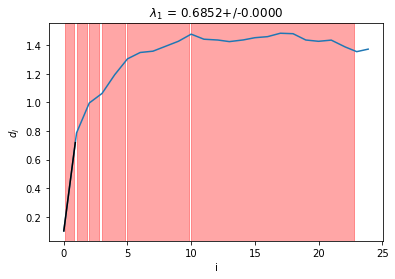

computed in  31.199771 s
Expected time remaining =  5197.722906500002 s

45 ) Computing  Thu 07 Mar 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


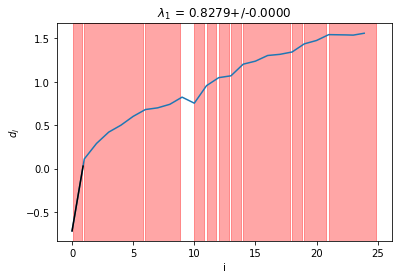

computed in  35.366151 s
Expected time remaining =  5221.371329777779 s

46 ) Computing  Fri 08 Mar 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


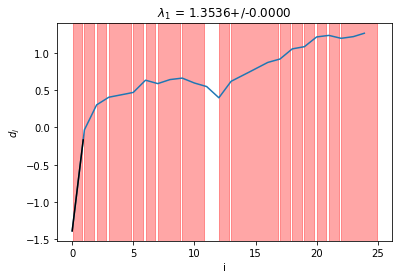

computed in  35.208764 s
Expected time remaining =  5241.745660500001 s

47 ) Computing  Mon 11 Mar 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


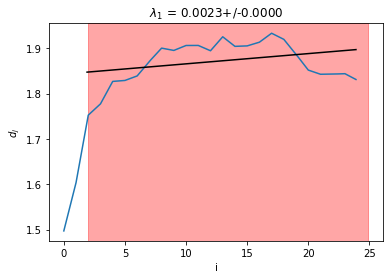

computed in  28.239542000000004 s
Expected time remaining =  5229.208801404256 s

48 ) Computing  Tue 12 Mar 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


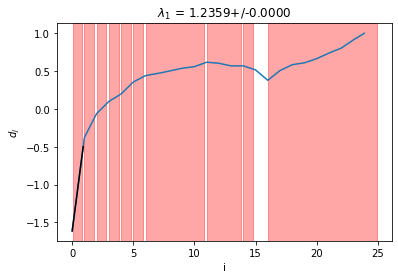

computed in  34.675286 s
Expected time remaining =  5243.503653854167 s

49 ) Computing  Wed 13 Mar 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


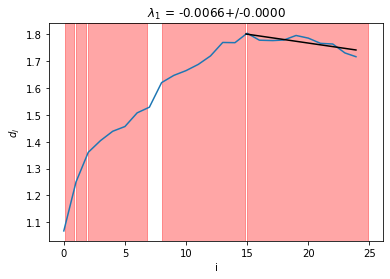

computed in  28.715927 s
Expected time remaining =  5230.989332571429 s

50 ) Computing  Thu 14 Mar 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


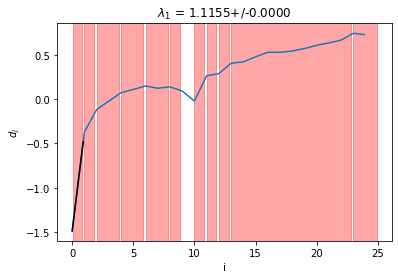

computed in  35.343519 s
Expected time remaining =  5244.734970580001 s

51 ) Computing  Fri 15 Mar 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


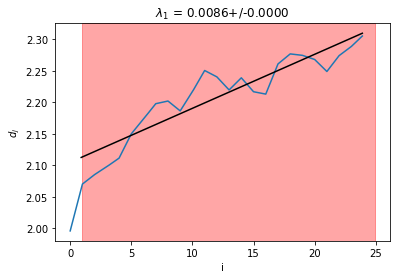

computed in  25.891582000000003 s
Expected time remaining =  5219.118459803922 s

52 ) Computing  Mon 18 Mar 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


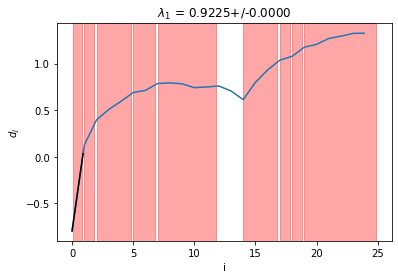

computed in  34.876310000000004 s
Expected time remaining =  5228.2207987500005 s

53 ) Computing  Tue 19 Mar 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


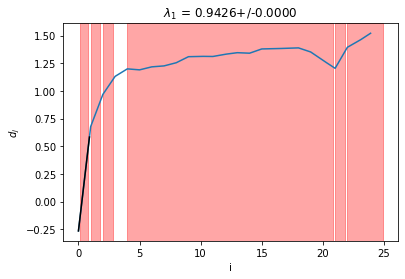

computed in  31.701925000000003 s
Expected time remaining =  5223.684754716983 s

54 ) Computing  Wed 20 Mar 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


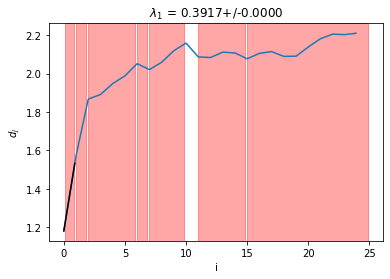

computed in  29.834237 s
Expected time remaining =  5211.259790796297 s

55 ) Computing  Thu 21 Mar 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


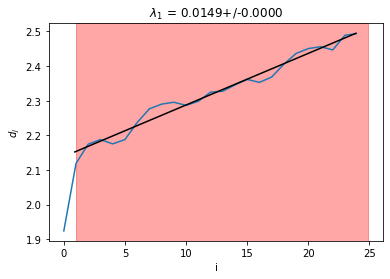

computed in  27.145313 s
Expected time remaining =  5188.521636000001 s

56 ) Computing  Fri 22 Mar 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


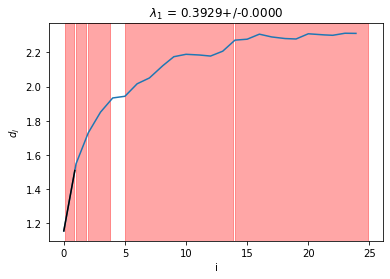

computed in  31.012213000000003 s
Expected time remaining =  5179.229284482143 s

57 ) Computing  Mon 25 Mar 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


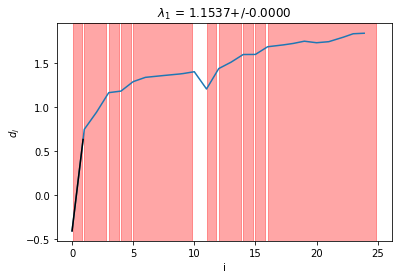

computed in  34.853073 s
Expected time remaining =  5182.3820002807015 s

58 ) Computing  Tue 26 Mar 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


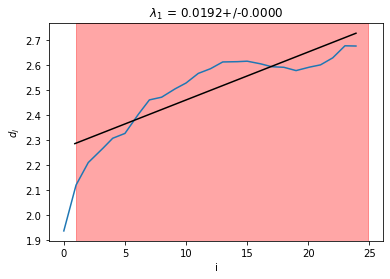

computed in  25.19869 s
Expected time remaining =  5151.765470172414 s

59 ) Computing  Wed 27 Mar 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


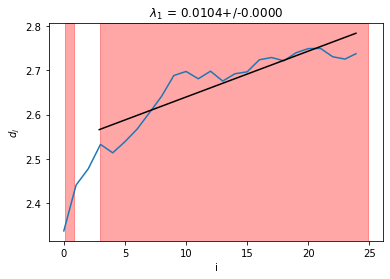

computed in  27.547751 s
Expected time remaining =  5129.0566267457625 s

60 ) Computing  Thu 28 Mar 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


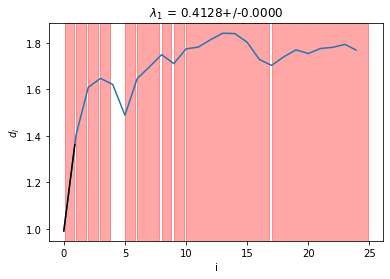

computed in  31.389115000000004 s
Expected time remaining =  5118.542873933334 s

61 ) Computing  Fri 29 Mar 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


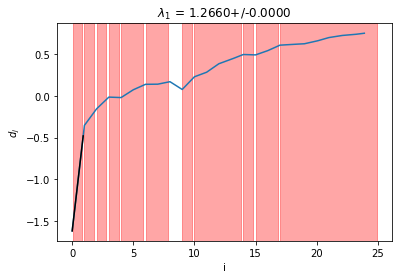

computed in  35.960660000000004 s
Expected time remaining =  5121.733808262295 s

62 ) Computing  Mon 01 Apr 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


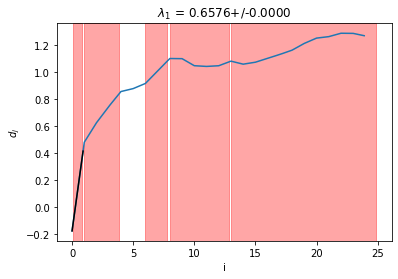

computed in  30.058584000000003 s
Expected time remaining =  5105.479586064516 s

63 ) Computing  Tue 02 Apr 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


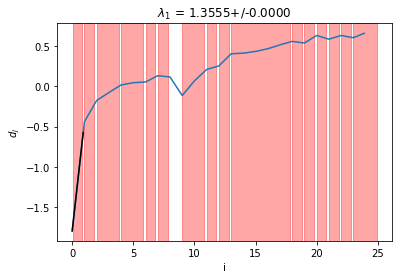

computed in  36.328646000000006 s
Expected time remaining =  5107.696840952381 s

64 ) Computing  Wed 03 Apr 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


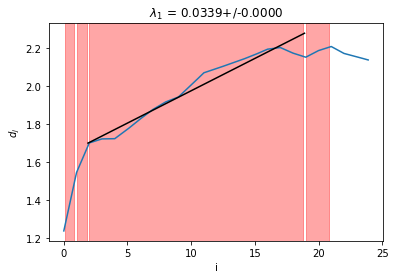

computed in  27.425306000000003 s
Expected time remaining =  5082.4168605 s

65 ) Computing  Thu 04 Apr 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


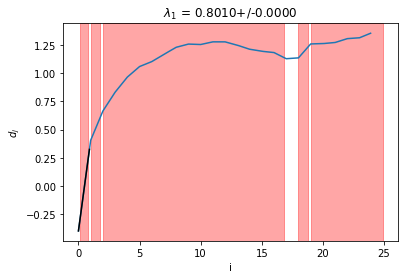

computed in  32.990975000000006 s
Expected time remaining =  5073.168497292308 s

66 ) Computing  Fri 05 Apr 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


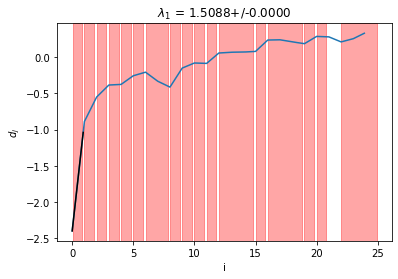

computed in  36.968516 s
Expected time remaining =  5074.4703604999995 s

67 ) Computing  Mon 08 Apr 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


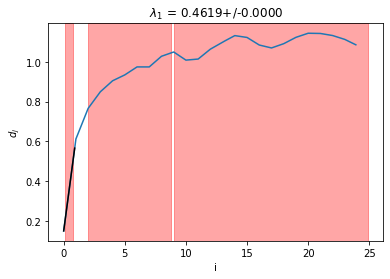

computed in  31.425515000000004 s
Expected time remaining =  5059.241791701492 s

68 ) Computing  Tue 09 Apr 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


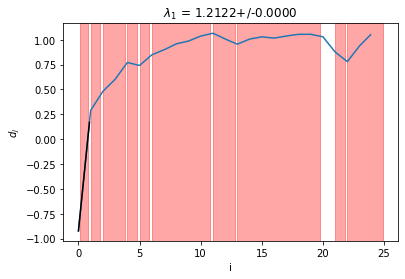

computed in  33.909018 s
Expected time remaining =  5050.29343117647 s

69 ) Computing  Wed 10 Apr 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


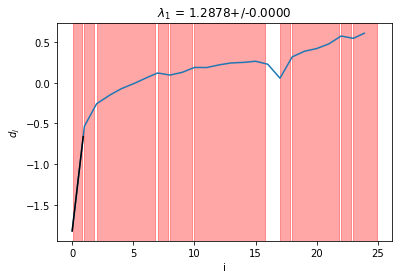

computed in  34.496853 s
Expected time remaining =  5042.189133333333 s

70 ) Computing  Thu 11 Apr 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


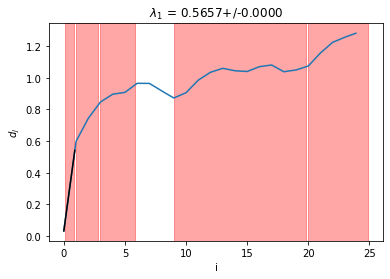

computed in  28.829009 s
Expected time remaining =  5018.513398885714 s

71 ) Computing  Fri 12 Apr 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


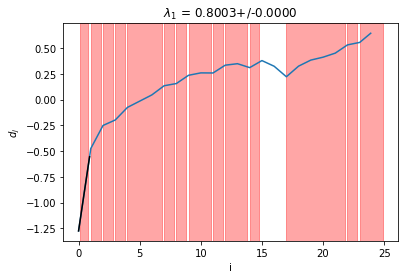

computed in  34.109911000000004 s
Expected time remaining =  5008.229461830986 s

72 ) Computing  Mon 15 Apr 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


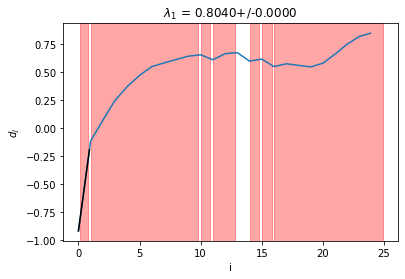

computed in  32.914284 s
Expected time remaining =  4994.278018736111 s

73 ) Computing  Tue 16 Apr 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


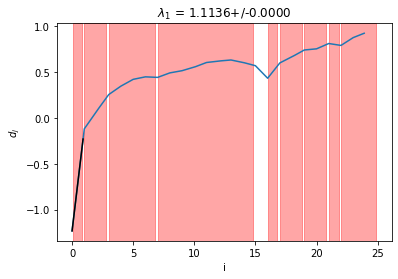

computed in  33.827983 s
Expected time remaining =  4982.060002191782 s

74 ) Computing  Wed 17 Apr 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


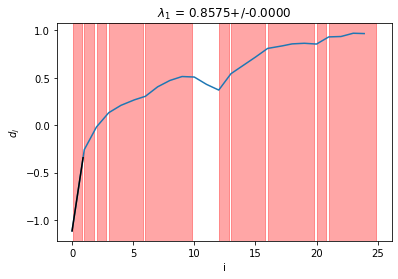

computed in  35.515156000000005 s
Expected time remaining =  4973.339067189189 s

75 ) Computing  Thu 18 Apr 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


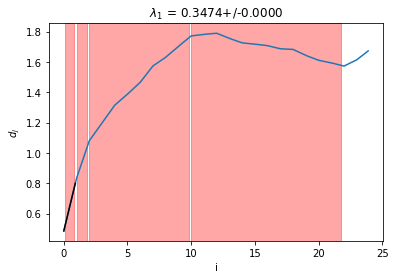

computed in  31.755288 s
Expected time remaining =  4954.980199573333 s

76 ) Computing  Mon 22 Apr 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


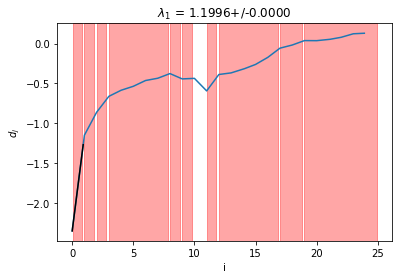

computed in  35.467744 s
Expected time remaining =  4944.914909210526 s

77 ) Computing  Tue 23 Apr 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


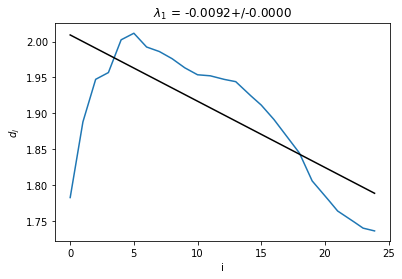

computed in  25.291113000000003 s
Expected time remaining =  4910.928944 s

78 ) Computing  Wed 24 Apr 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


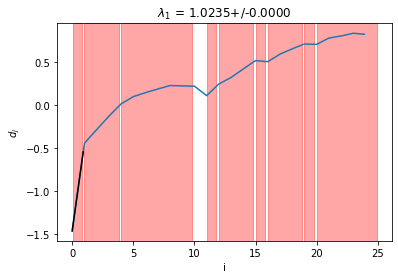

computed in  35.864501 s
Expected time remaining =  4900.888268589744 s

79 ) Computing  Thu 25 Apr 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


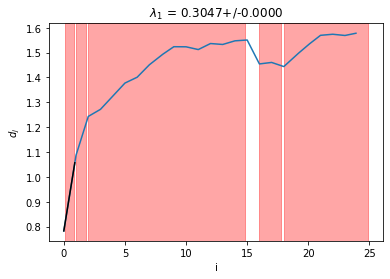

computed in  29.557109000000004 s
Expected time remaining =  4876.301594962025 s

80 ) Computing  Fri 26 Apr 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


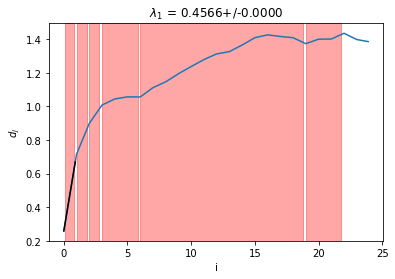

computed in  33.156679 s
Expected time remaining =  4859.374730575 s

81 ) Computing  Mon 29 Apr 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


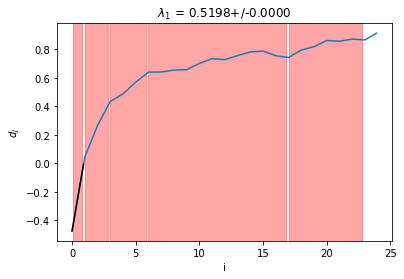

computed in  32.58261 s
Expected time remaining =  4840.828119308642 s

82 ) Computing  Tue 30 Apr 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


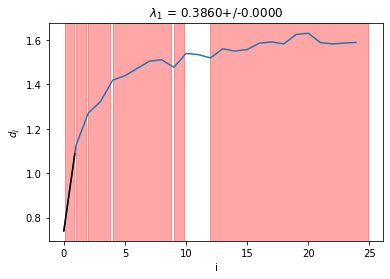

computed in  32.128495 s
Expected time remaining =  4820.992170695122 s

83 ) Computing  Wed 01 May 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


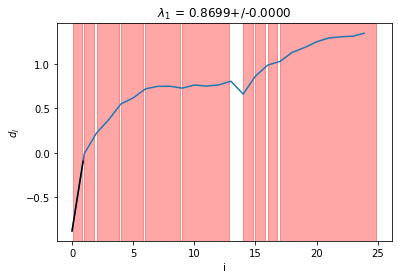

computed in  37.847756000000004 s
Expected time remaining =  4812.574165180723 s

84 ) Computing  Thu 02 May 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


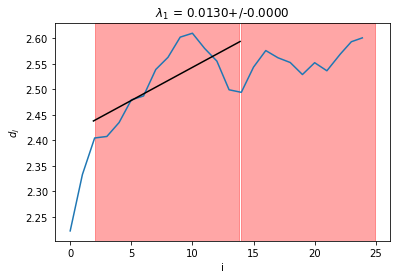

computed in  29.936278 s
Expected time remaining =  4787.538311059524 s

85 ) Computing  Fri 03 May 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


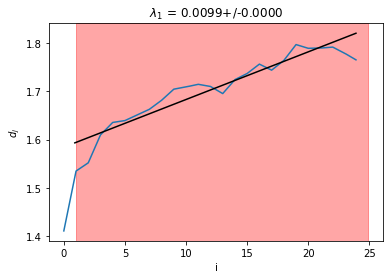

computed in  27.535995000000003 s
Expected time remaining =  4757.643064094119 s

86 ) Computing  Mon 06 May 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


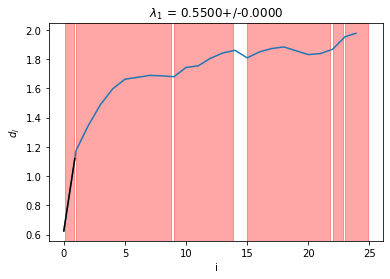

computed in  33.273627000000005 s
Expected time remaining =  4738.944364197676 s

87 ) Computing  Tue 07 May 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


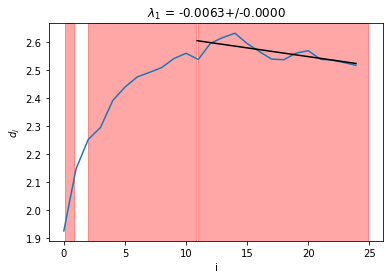

computed in  33.342049 s
Expected time remaining =  4720.041160827587 s

88 ) Computing  Wed 08 May 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


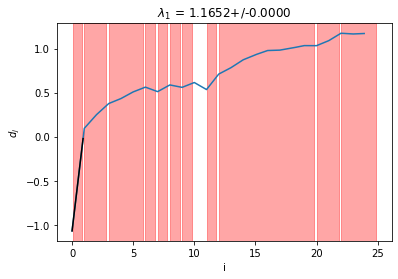

computed in  38.297830000000005 s
Expected time remaining =  4710.10189125 s

89 ) Computing  Thu 09 May 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


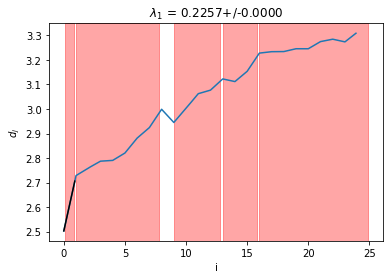

computed in  28.075623 s
Expected time remaining =  4680.688924269664 s

90 ) Computing  Fri 10 May 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


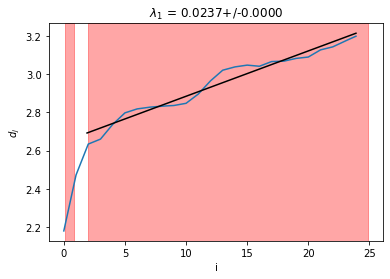

computed in  28.748269 s
Expected time remaining =  4652.52391268889 s

91 ) Computing  Mon 13 May 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


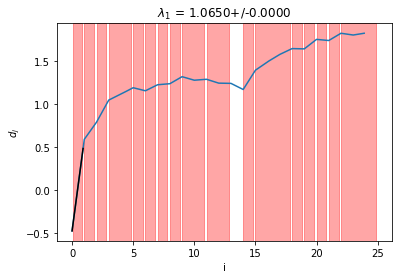

computed in  38.04498100000001 s
Expected time remaining =  4640.896272857144 s

92 ) Computing  Tue 14 May 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


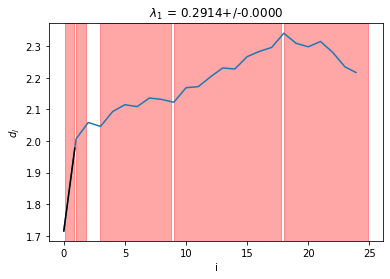

computed in  29.954273000000004 s
Expected time remaining =  4614.535604000001 s

93 ) Computing  Wed 15 May 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


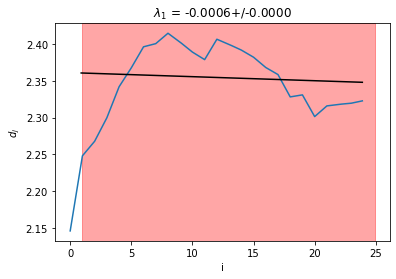

computed in  29.982454000000004 s
Expected time remaining =  4588.146136774195 s

94 ) Computing  Thu 16 May 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


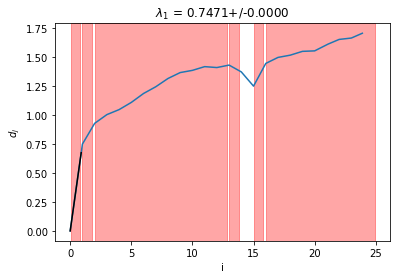

computed in  37.425581 s
Expected time remaining =  4574.270193159576 s

95 ) Computing  Fri 17 May 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


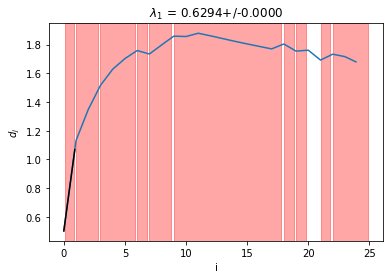

computed in  33.96506 s
Expected time remaining =  4554.143074884211 s

96 ) Computing  Mon 20 May 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


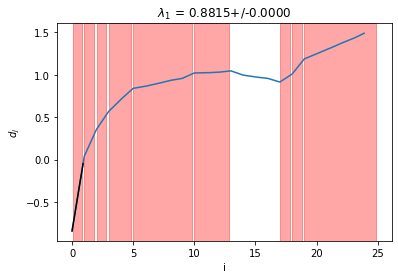

computed in  36.855143000000005 s
Expected time remaining =  4538.454156062501 s

97 ) Computing  Tue 21 May 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


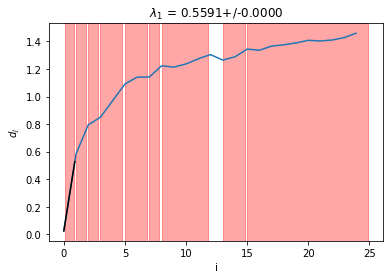

computed in  33.798101 s
Expected time remaining =  4517.412340329898 s

98 ) Computing  Wed 22 May 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


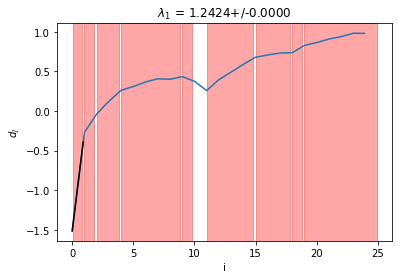

computed in  38.825959 s
Expected time remaining =  4504.062416632653 s

99 ) Computing  Thu 23 May 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


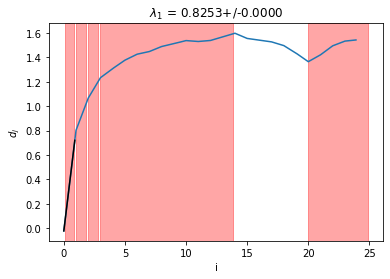

computed in  36.182016000000004 s
Expected time remaining =  4486.085025333335 s

100 ) Computing  Fri 24 May 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


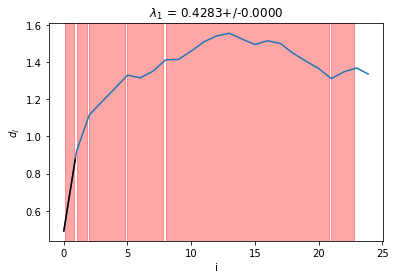

computed in  34.910117 s
Expected time remaining =  4465.797536070001 s

101 ) Computing  Tue 28 May 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


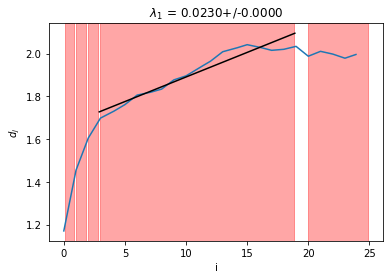

computed in  33.228729 s
Expected time remaining =  4442.690084118813 s

102 ) Computing  Wed 29 May 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


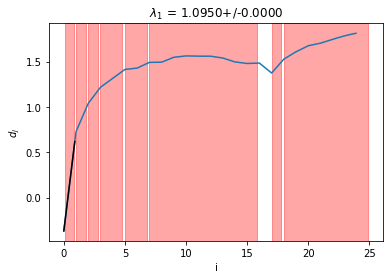

computed in  36.460714 s
Expected time remaining =  4424.168781 s

103 ) Computing  Thu 30 May 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


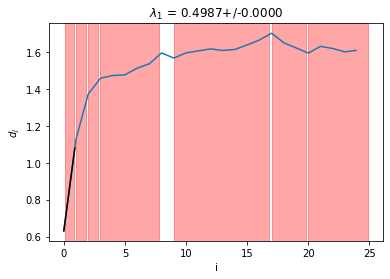

computed in  32.415963000000005 s
Expected time remaining =  4399.408725728155 s

104 ) Computing  Fri 31 May 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


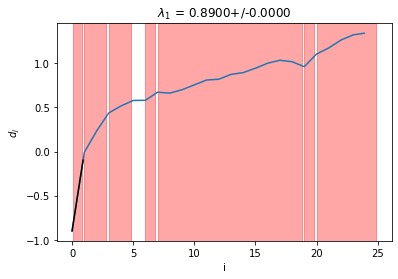

computed in  36.750498 s
Expected time remaining =  4380.711496413462 s

105 ) Computing  Mon 03 Jun 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


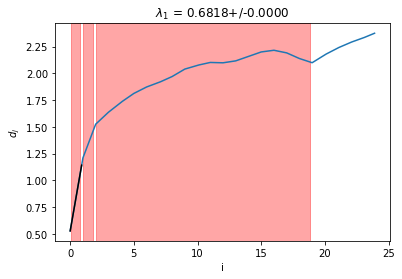

computed in  35.749985 s
Expected time remaining =  4360.260148419048 s

106 ) Computing  Tue 04 Jun 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


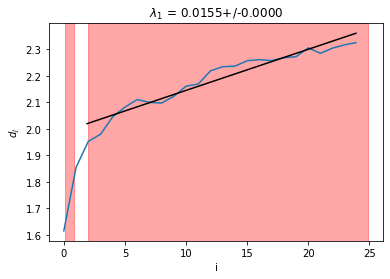

computed in  30.173982000000002 s
Expected time remaining =  4331.787388018868 s

107 ) Computing  Wed 05 Jun 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


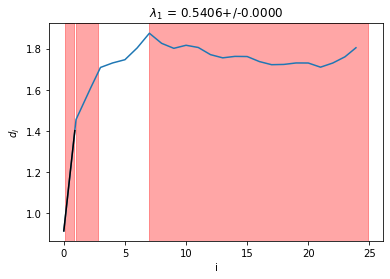

computed in  31.909373000000002 s
Expected time remaining =  4305.650745775701 s

108 ) Computing  Thu 06 Jun 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


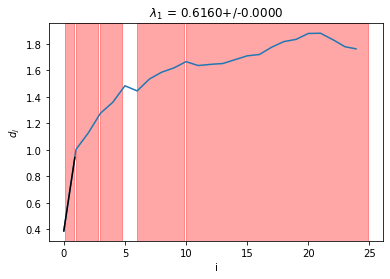

computed in  33.287195000000004 s
Expected time remaining =  4281.257054722222 s

109 ) Computing  Fri 07 Jun 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


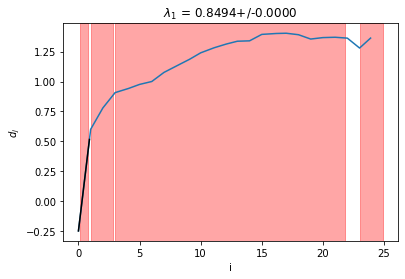

computed in  35.515739 s
Expected time remaining =  4259.644311633027 s

110 ) Computing  Mon 10 Jun 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


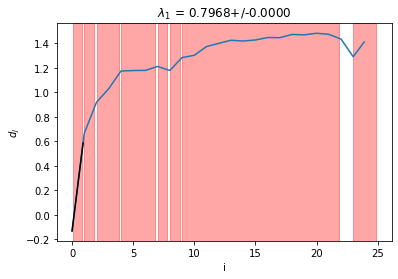

computed in  34.719401000000005 s
Expected time remaining =  4236.743547399999 s

111 ) Computing  Tue 11 Jun 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


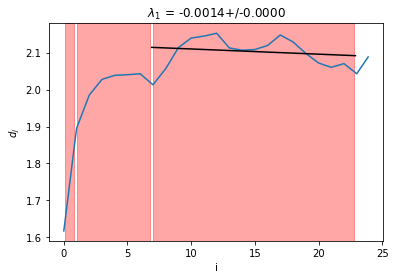

computed in  28.632474000000002 s
Expected time remaining =  4205.842955171171 s

112 ) Computing  Wed 12 Jun 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


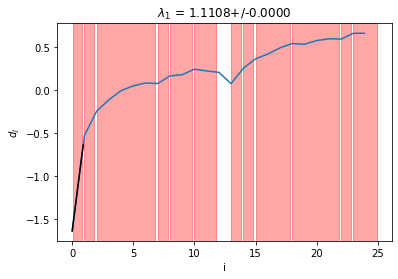

computed in  37.780671000000005 s
Expected time remaining =  4186.499791633929 s

113 ) Computing  Thu 13 Jun 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


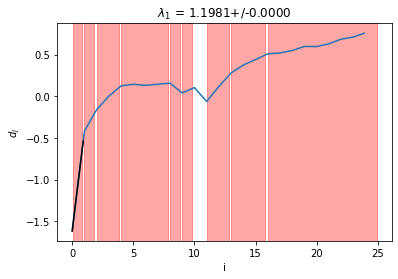

computed in  38.322987999999995 s
Expected time remaining =  4167.502197699116 s

114 ) Computing  Fri 14 Jun 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


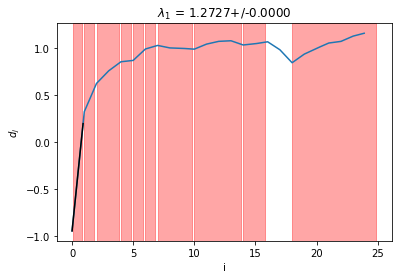

computed in  36.38844 s
Expected time remaining =  4145.806770780702 s

115 ) Computing  Mon 17 Jun 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


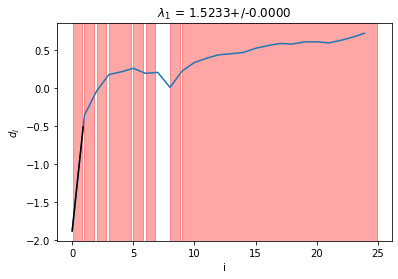

computed in  39.38763300000001 s
Expected time remaining =  4127.4548448000005 s

116 ) Computing  Tue 18 Jun 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


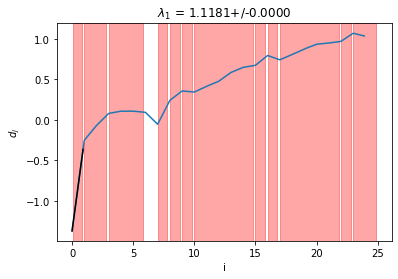

computed in  39.50258000000001 s
Expected time remaining =  4108.875990586207 s

117 ) Computing  Wed 19 Jun 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


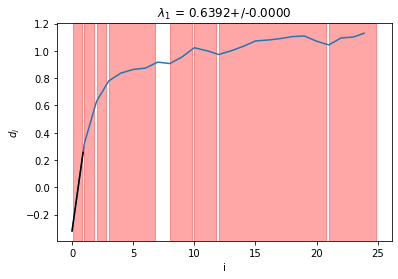

computed in  25.555077 s
Expected time remaining =  4073.7269837264953 s

118 ) Computing  Thu 20 Jun 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


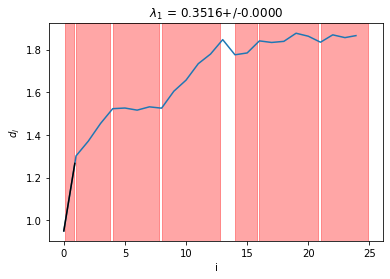

computed in  23.947997 s
Expected time remaining =  4036.9019773728814 s

119 ) Computing  Fri 21 Jun 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


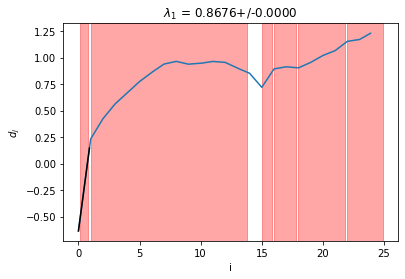

computed in  28.201703000000002 s
Expected time remaining =  4005.0832787731097 s

120 ) Computing  Mon 24 Jun 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


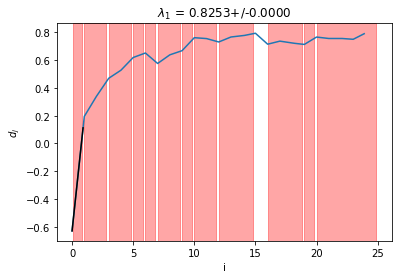

computed in  25.326052 s
Expected time remaining =  3970.1376835750007 s

121 ) Computing  Tue 25 Jun 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


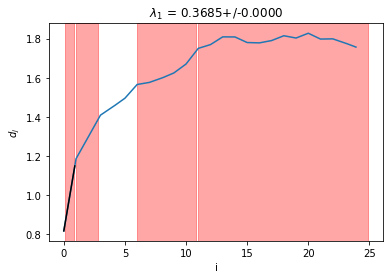

computed in  25.762785000000004 s
Expected time remaining =  3935.8275250909096 s

122 ) Computing  Wed 26 Jun 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


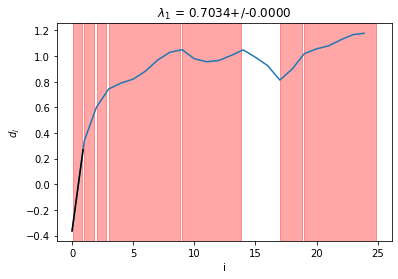

computed in  27.683293000000003 s
Expected time remaining =  3903.7196723032794 s

123 ) Computing  Thu 27 Jun 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


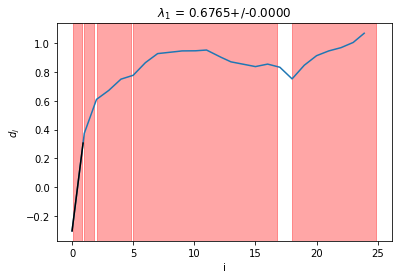

computed in  27.4369 s
Expected time remaining =  3871.423348211383 s

124 ) Computing  Fri 28 Jun 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


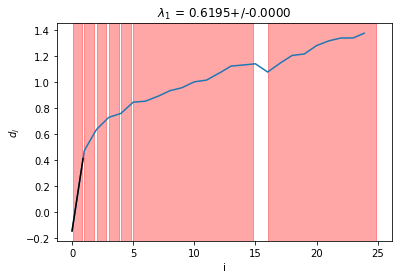

computed in  28.146572 s
Expected time remaining =  3839.943689733872 s

125 ) Computing  Mon 01 Jul 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


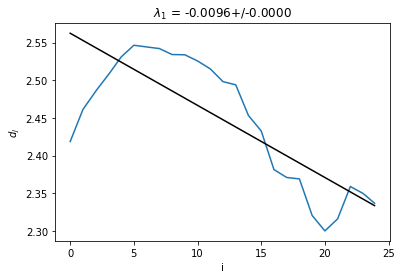

computed in  21.935370000000002 s
Expected time remaining =  3802.157089792001 s

126 ) Computing  Tue 02 Jul 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


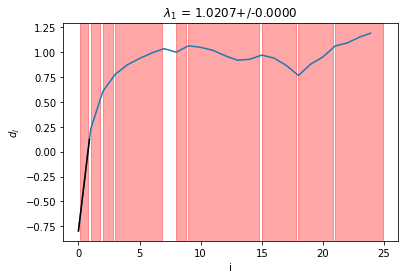

computed in  27.900915 s
Expected time remaining =  3770.6349872698424 s

127 ) Computing  Wed 03 Jul 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


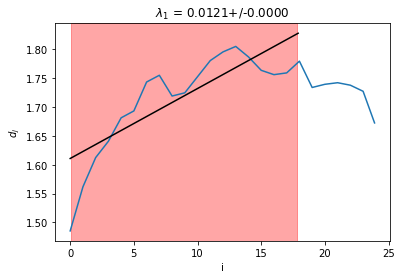

computed in  7.8802010000000005 s
Expected time remaining =  3719.3068407401583 s

128 ) Computing  Fri 05 Jul 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


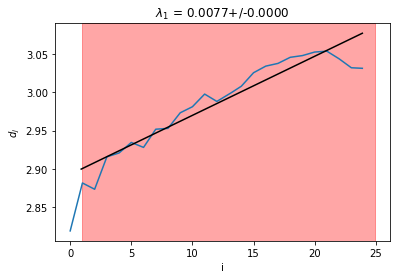

computed in  18.112804000000004 s
Expected time remaining =  3678.650344726563 s

129 ) Computing  Mon 08 Jul 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


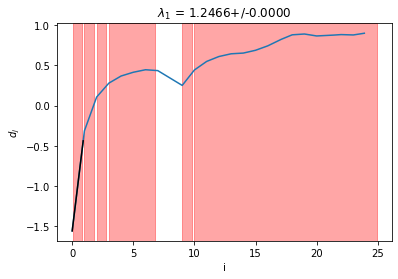

computed in  29.587077000000004 s
Expected time remaining =  3649.372897054264 s

130 ) Computing  Tue 09 Jul 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


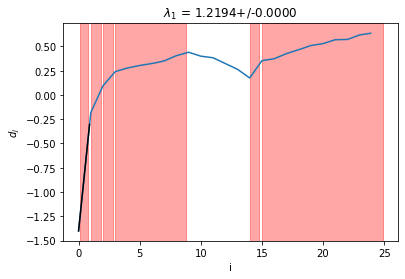

computed in  28.964471000000003 s
Expected time remaining =  3619.501604792308 s

131 ) Computing  Wed 10 Jul 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


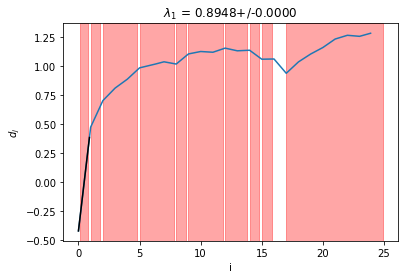

computed in  27.321595000000002 s
Expected time remaining =  3588.1141504732827 s

132 ) Computing  Thu 11 Jul 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


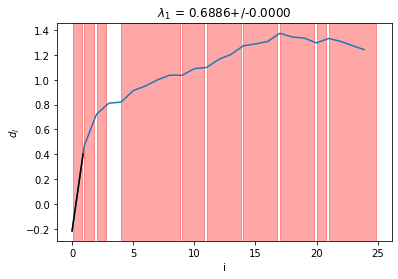

computed in  24.827722 s
Expected time remaining =  3554.5022498333337 s

133 ) Computing  Fri 12 Jul 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


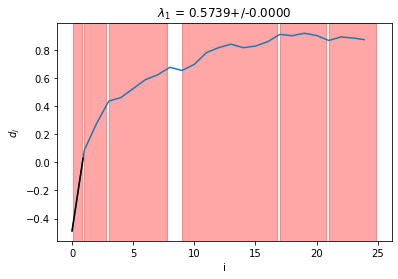

computed in  26.524026 s
Expected time remaining =  3522.5529419548875 s

134 ) Computing  Mon 15 Jul 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


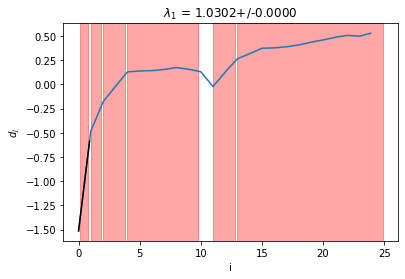

computed in  29.403794 s
Expected time remaining =  3493.2420143432837 s

135 ) Computing  Tue 16 Jul 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


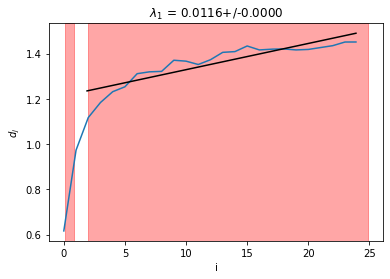

computed in  23.749317 s
Expected time remaining =  3458.9872791851853 s

136 ) Computing  Wed 17 Jul 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


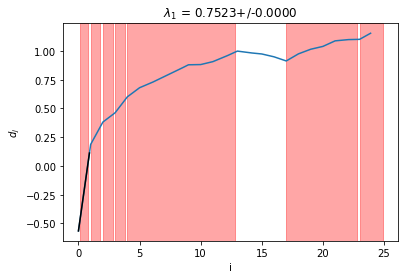

computed in  28.454716000000005 s
Expected time remaining =  3428.9350625514708 s

137 ) Computing  Thu 18 Jul 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


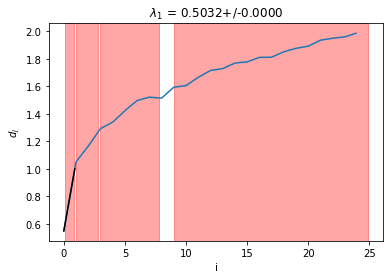

computed in  24.031982000000003 s
Expected time remaining =  3395.1613704233578 s

138 ) Computing  Fri 19 Jul 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


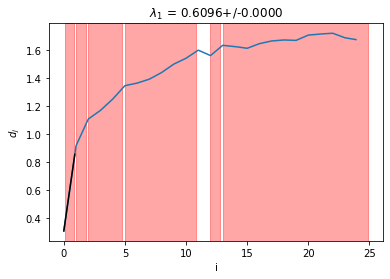

computed in  26.119599 s
Expected time remaining =  3363.2685433333336 s

139 ) Computing  Mon 22 Jul 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


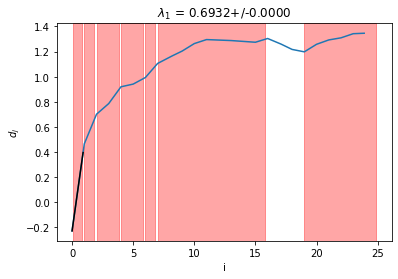

computed in  26.768203 s
Expected time remaining =  3331.990732877698 s

140 ) Computing  Tue 23 Jul 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


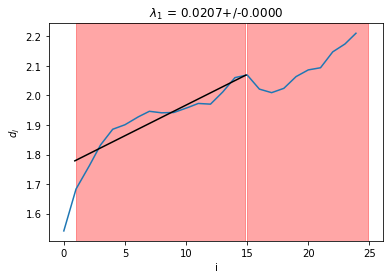

computed in  21.247324000000003 s
Expected time remaining =  3296.3212073357145 s

141 ) Computing  Wed 24 Jul 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


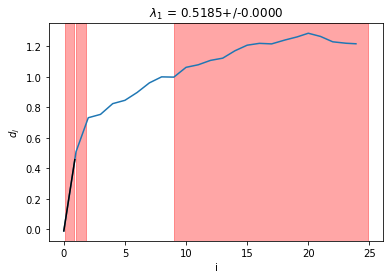

computed in  26.148611 s
Expected time remaining =  3264.7494729078016 s

142 ) Computing  Thu 25 Jul 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


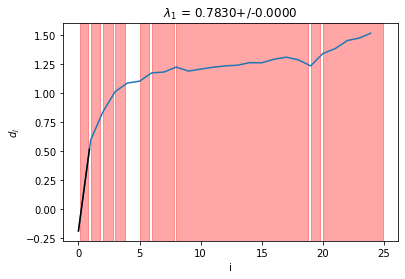

computed in  27.475583000000004 s
Expected time remaining =  3234.291401429577 s

143 ) Computing  Fri 26 Jul 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


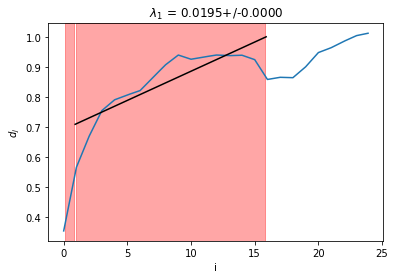

computed in  23.937805 s
Expected time remaining =  3201.1536753846153 s

144 ) Computing  Mon 29 Jul 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


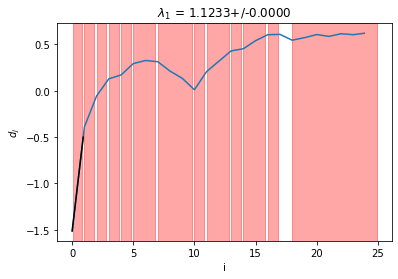

computed in  29.292412 s
Expected time remaining =  3172.1968660416665 s

145 ) Computing  Tue 30 Jul 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


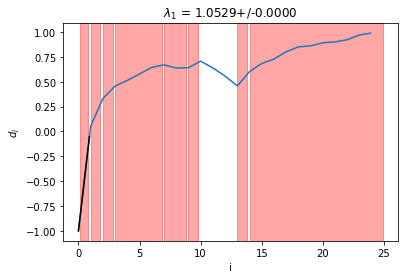

computed in  28.840236000000004 s
Expected time remaining =  3142.8986345379312 s

146 ) Computing  Wed 31 Jul 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


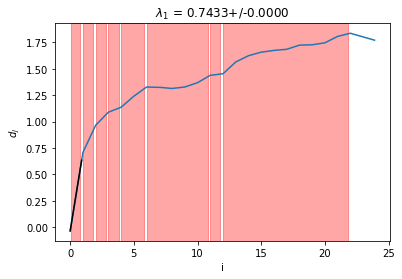

computed in  26.468368 s
Expected time remaining =  3111.8683901232876 s

147 ) Computing  Thu 01 Aug 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


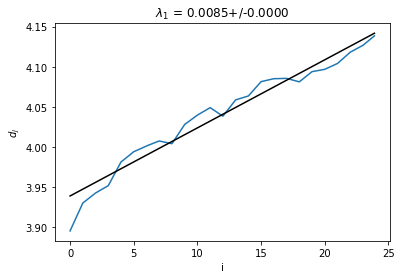

computed in  18.16451 s
Expected time remaining =  3074.9123960816332 s

148 ) Computing  Fri 02 Aug 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


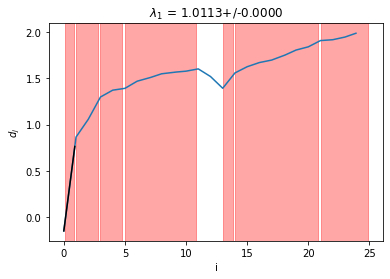

computed in  28.326893000000002 s
Expected time remaining =  3045.4201397635134 s

149 ) Computing  Mon 05 Aug 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


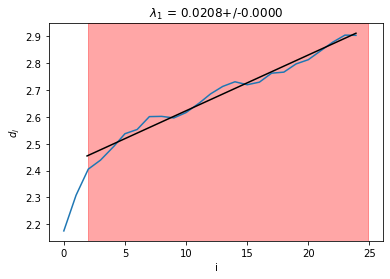

computed in  23.270383000000002 s
Expected time remaining =  3012.414149798658 s

150 ) Computing  Tue 06 Aug 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


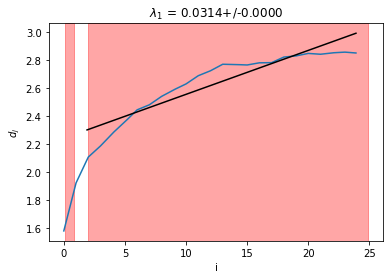

computed in  23.376033000000003 s
Expected time remaining =  2979.61051426 s

151 ) Computing  Wed 07 Aug 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


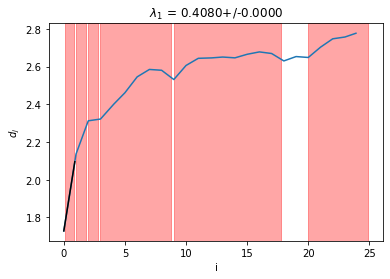

computed in  24.786064 s
Expected time remaining =  2947.8842189006623 s

152 ) Computing  Thu 08 Aug 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


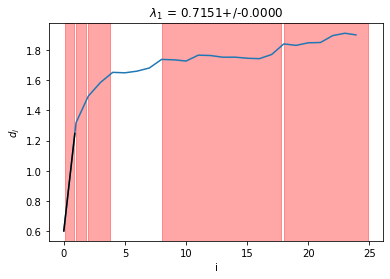

computed in  25.176425000000002 s
Expected time remaining =  2916.508626986842 s

153 ) Computing  Fri 09 Aug 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


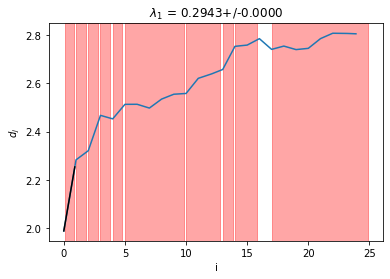

computed in  23.982901000000002 s
Expected time remaining =  2884.433988888889 s

154 ) Computing  Mon 12 Aug 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


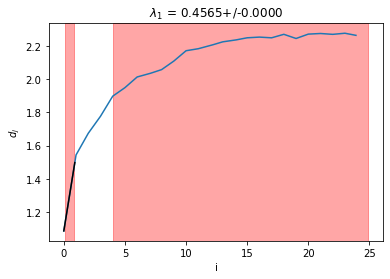

computed in  24.048188 s
Expected time remaining =  2852.5064085 s

155 ) Computing  Tue 13 Aug 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


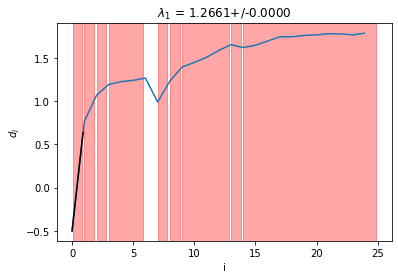

computed in  27.847089999999998 s
Expected time remaining =  2823.082384116129 s

156 ) Computing  Wed 14 Aug 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


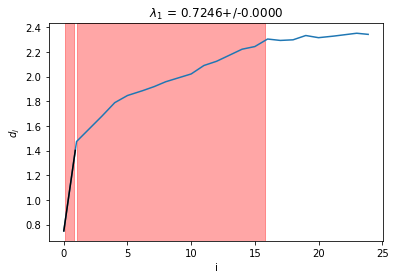

computed in  25.927000000000003 s
Expected time remaining =  2792.4846747243596 s

157 ) Computing  Thu 15 Aug 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


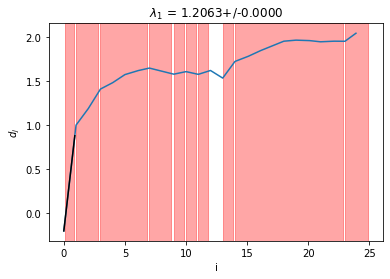

computed in  25.848008000000004 s
Expected time remaining =  2761.8981639745225 s

158 ) Computing  Fri 16 Aug 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


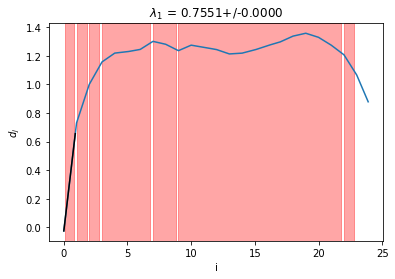

computed in  26.694044 s
Expected time remaining =  2731.8803268037977 s

159 ) Computing  Mon 19 Aug 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


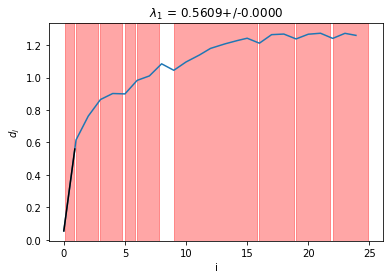

computed in  26.492134000000004 s
Expected time remaining =  2701.784930176101 s

160 ) Computing  Tue 20 Aug 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


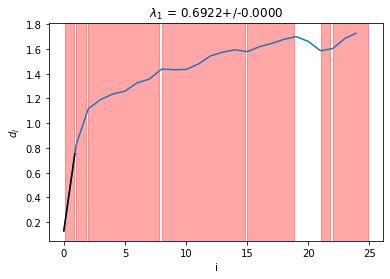

computed in  27.218373000000003 s
Expected time remaining =  2672.1567007500003 s

161 ) Computing  Wed 21 Aug 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


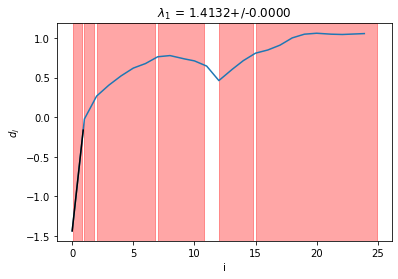

computed in  29.284921 s
Expected time remaining =  2643.7392920000007 s

162 ) Computing  Thu 22 Aug 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


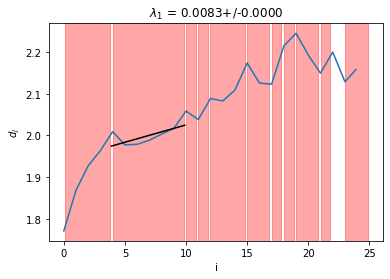

computed in  24.990140000000004 s
Expected time remaining =  2612.898672783951 s

163 ) Computing  Fri 23 Aug 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


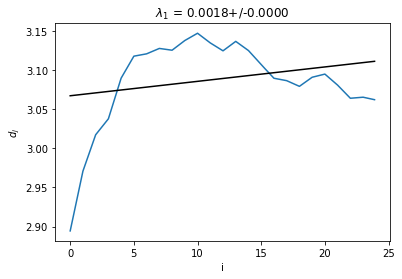

computed in  20.997969000000005 s
Expected time remaining =  2579.9255723926385 s

164 ) Computing  Mon 26 Aug 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


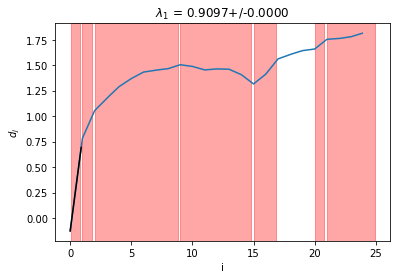

computed in  26.277315 s
Expected time remaining =  2549.963521128049 s

165 ) Computing  Tue 27 Aug 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


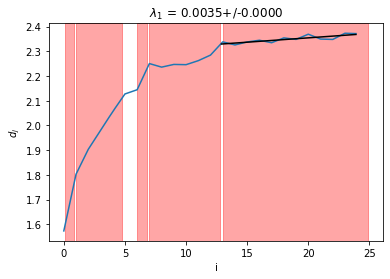

computed in  22.365039 s
Expected time remaining =  2517.9595861333337 s

166 ) Computing  Wed 28 Aug 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


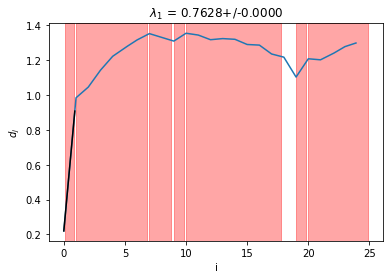

computed in  24.985571 s
Expected time remaining =  2487.44519376506 s

167 ) Computing  Thu 29 Aug 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


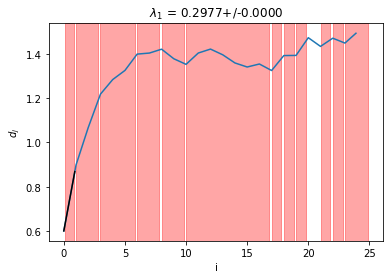

computed in  22.732942000000005 s
Expected time remaining =  2455.836978335329 s

168 ) Computing  Fri 30 Aug 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


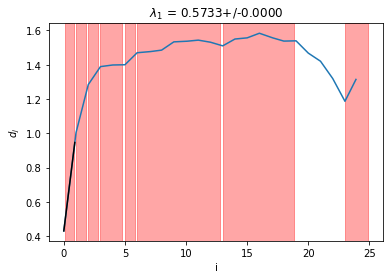

computed in  23.773796000000004 s
Expected time remaining =  2424.8610434821426 s

169 ) Computing  Tue 03 Sep 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


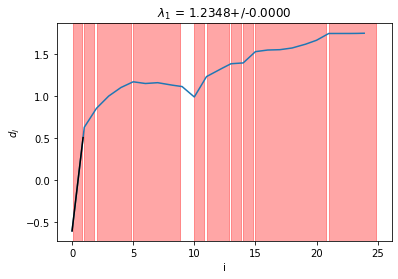

computed in  27.102981 s
Expected time remaining =  2395.625083881657 s

170 ) Computing  Wed 04 Sep 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


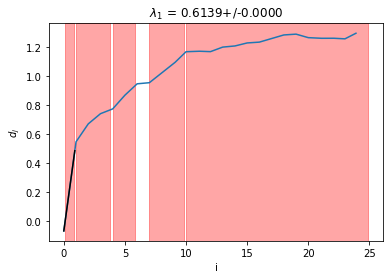

computed in  23.35649 s
Expected time remaining =  2364.5850490117646 s

171 ) Computing  Thu 05 Sep 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


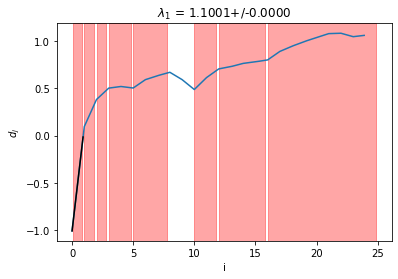

computed in  27.319047000000005 s
Expected time remaining =  2335.5350536959068 s

172 ) Computing  Fri 06 Sep 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


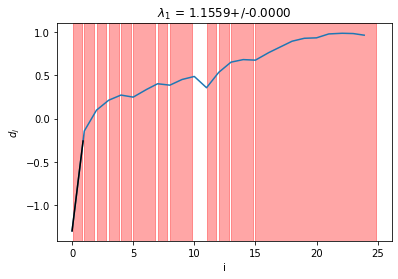

computed in  26.524481 s
Expected time remaining =  2306.1310005348837 s

173 ) Computing  Mon 09 Sep 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


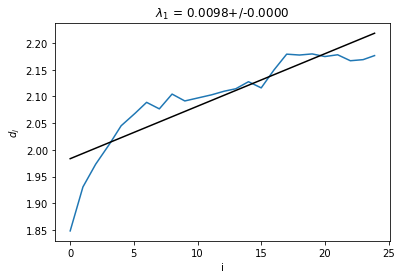

computed in  19.763919 s
Expected time remaining =  2273.633965780347 s

174 ) Computing  Tue 10 Sep 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


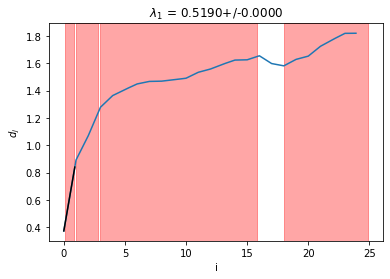

computed in  25.163253000000005 s
Expected time remaining =  2243.734710436782 s

175 ) Computing  Wed 11 Sep 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


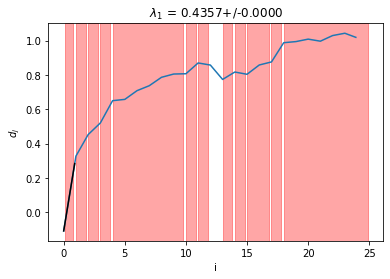

computed in  24.652567000000005 s
Expected time remaining =  2213.6619607885714 s

176 ) Computing  Thu 12 Sep 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


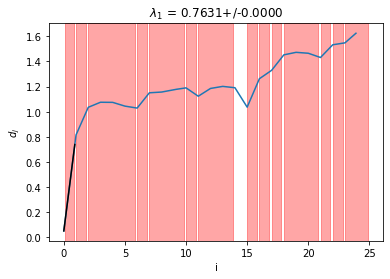

computed in  25.324339000000002 s
Expected time remaining =  2183.944704375 s

177 ) Computing  Fri 13 Sep 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


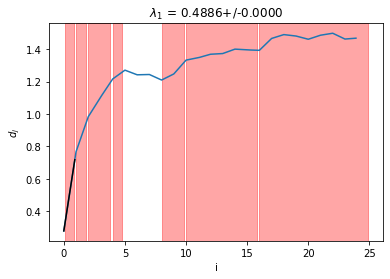

computed in  23.313954000000003 s
Expected time remaining =  2153.413869288136 s

178 ) Computing  Mon 16 Sep 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


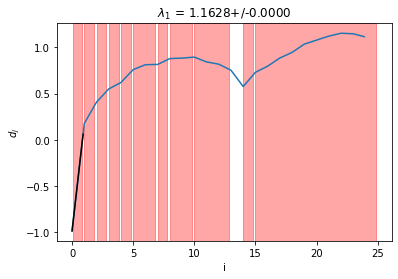

computed in  26.370569000000003 s
Expected time remaining =  2124.252022331461 s

179 ) Computing  Tue 17 Sep 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


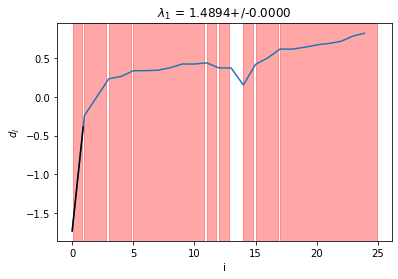

computed in  26.986772000000002 s
Expected time remaining =  2095.376105977654 s

180 ) Computing  Wed 18 Sep 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


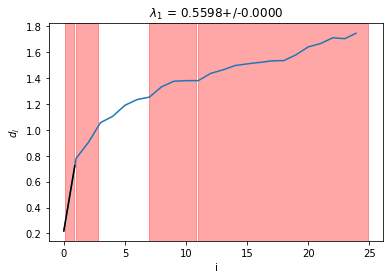

computed in  24.595523000000004 s
Expected time remaining =  2065.5513958 s

181 ) Computing  Thu 19 Sep 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


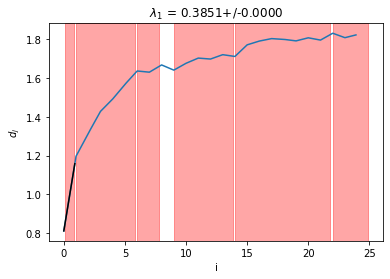

computed in  22.877290000000002 s
Expected time remaining =  2035.100970696133 s

182 ) Computing  Fri 20 Sep 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


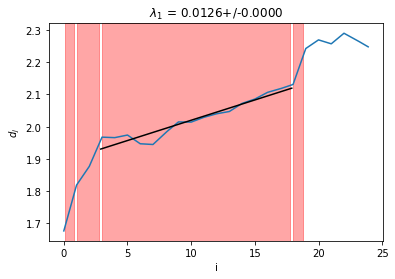

computed in  22.293804000000005 s
Expected time remaining =  2004.5061431978024 s

183 ) Computing  Mon 23 Sep 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


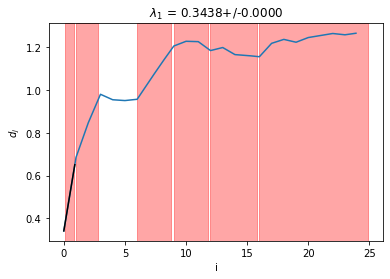

computed in  22.401901000000002 s
Expected time remaining =  1974.0433858469949 s

184 ) Computing  Tue 24 Sep 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


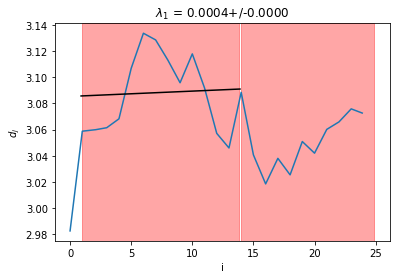

computed in  19.833007000000002 s
Expected time remaining =  1942.7049112500001 s

185 ) Computing  Wed 25 Sep 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


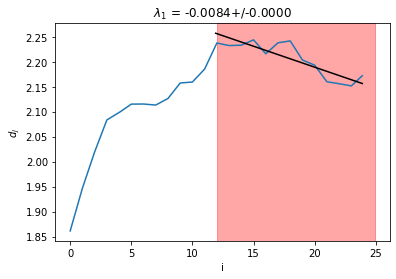

computed in  21.646364 s
Expected time remaining =  1912.1573513081082 s

186 ) Computing  Thu 26 Sep 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


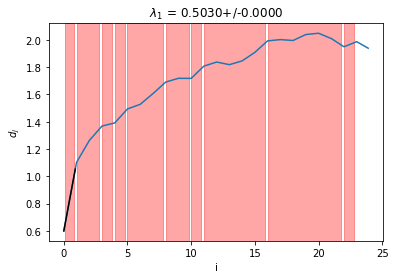

computed in  23.514053 s
Expected time remaining =  1882.3782728440865 s

187 ) Computing  Fri 27 Sep 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


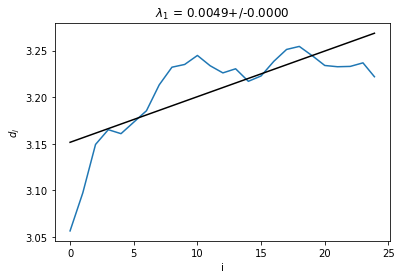

computed in  19.360993 s
Expected time remaining =  1851.2004141176471 s

188 ) Computing  Mon 30 Sep 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


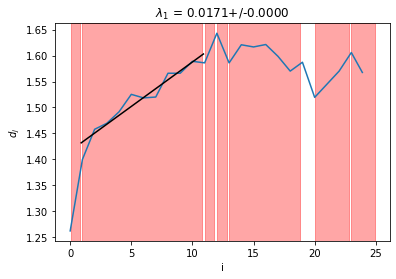

computed in  21.076331000000003 s
Expected time remaining =  1820.7413357180853 s

189 ) Computing  Tue 01 Oct 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


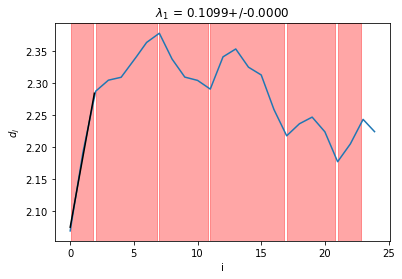

computed in  23.138003 s
Expected time remaining =  1791.0796779682541 s

190 ) Computing  Wed 02 Oct 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


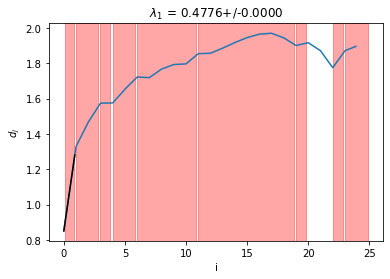

computed in  24.673330000000004 s
Expected time remaining =  1761.995772378948 s

191 ) Computing  Thu 03 Oct 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


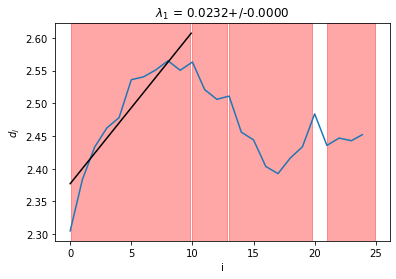

computed in  22.485799999999998 s
Expected time remaining =  1732.247962554974 s

192 ) Computing  Fri 04 Oct 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


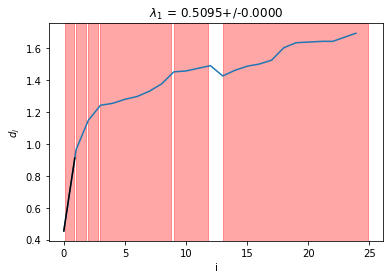

computed in  24.331849000000005 s
Expected time remaining =  1703.1623038177086 s

193 ) Computing  Mon 07 Oct 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


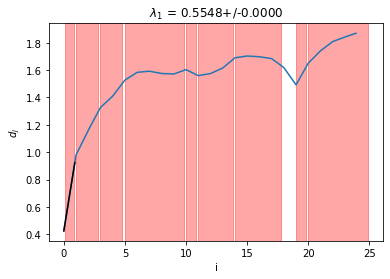

computed in  23.948542000000003 s
Expected time remaining =  1674.0067445595857 s

194 ) Computing  Tue 08 Oct 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


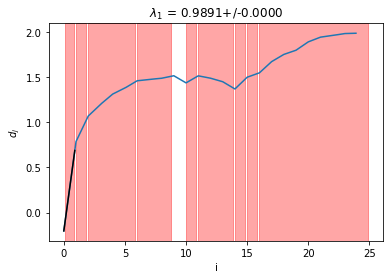

computed in  26.570474 s
Expected time remaining =  1645.7022575824747 s

195 ) Computing  Wed 09 Oct 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


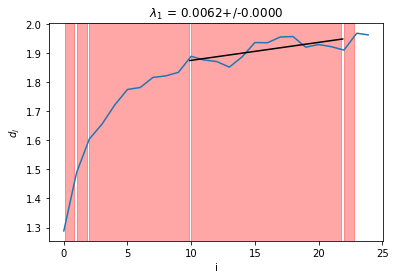

computed in  22.304591 s
Expected time remaining =  1616.146728615385 s

196 ) Computing  Thu 10 Oct 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


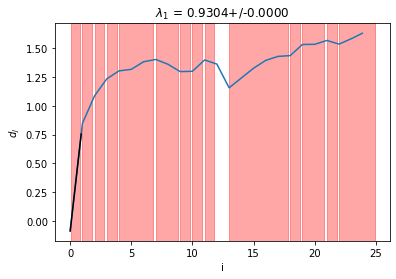

computed in  26.037717 s
Expected time remaining =  1587.7508428010208 s

197 ) Computing  Fri 11 Oct 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


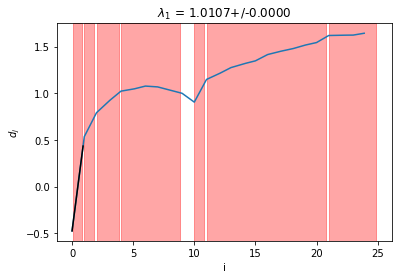

computed in  26.392409 s
Expected time remaining =  1559.4797239390869 s

198 ) Computing  Mon 14 Oct 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


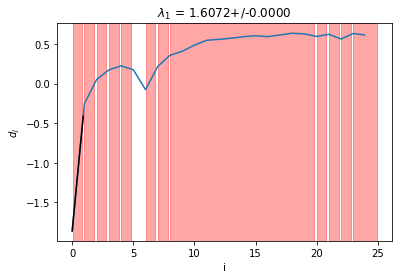

computed in  27.982277000000003 s
Expected time remaining =  1531.669211944445 s

199 ) Computing  Tue 15 Oct 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


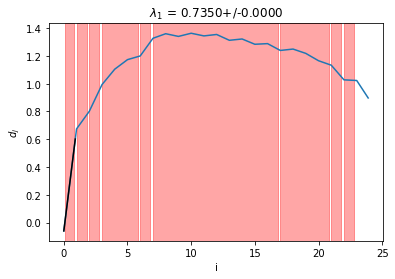

computed in  23.647027 s
Expected time remaining =  1502.6805741708547 s

200 ) Computing  Wed 16 Oct 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


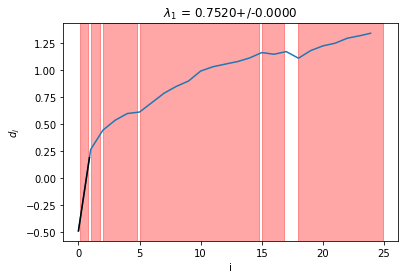

computed in  24.538306000000002 s
Expected time remaining =  1473.9815414400002 s

201 ) Computing  Thu 17 Oct 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


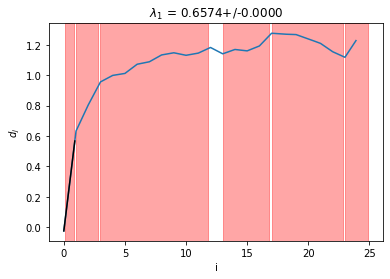

computed in  23.785849000000002 s
Expected time remaining =  1445.1292434825873 s

202 ) Computing  Fri 18 Oct 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


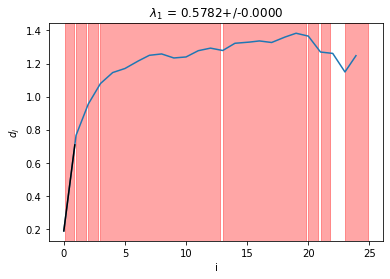

computed in  23.669415 s
Expected time remaining =  1416.2977116831685 s

203 ) Computing  Mon 21 Oct 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


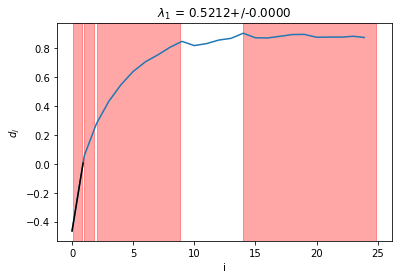

computed in  24.265236 s
Expected time remaining =  1387.6637921182269 s

204 ) Computing  Tue 22 Oct 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


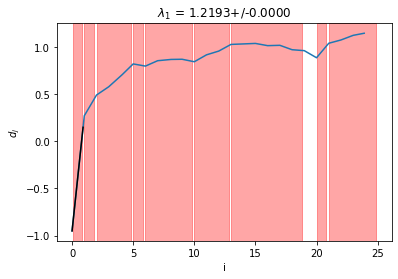

computed in  24.825825000000002 s
Expected time remaining =  1359.2073540637257 s

205 ) Computing  Wed 23 Oct 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


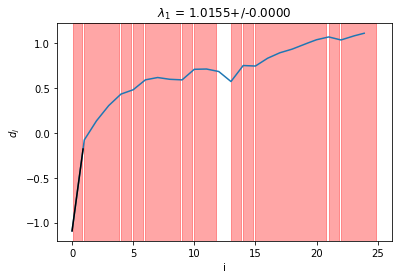

computed in  26.831139 s
Expected time remaining =  1331.255873560976 s

206 ) Computing  Thu 24 Oct 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


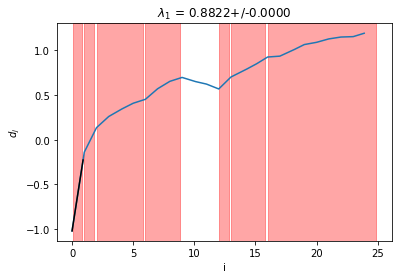

computed in  26.020288000000004 s
Expected time remaining =  1303.1302701747575 s

207 ) Computing  Fri 25 Oct 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


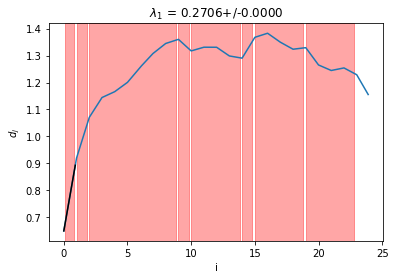

computed in  23.575604 s
Expected time remaining =  1274.481744888889 s

208 ) Computing  Mon 28 Oct 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


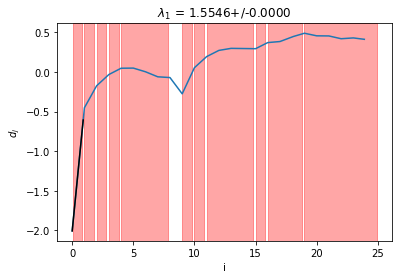

computed in  27.754399000000003 s
Expected time remaining =  1246.786063918269 s

209 ) Computing  Tue 29 Oct 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


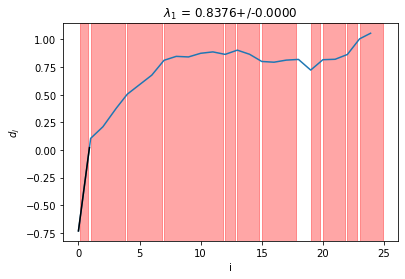

computed in  24.156949 s
Expected time remaining =  1218.3324631578948 s

210 ) Computing  Wed 30 Oct 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


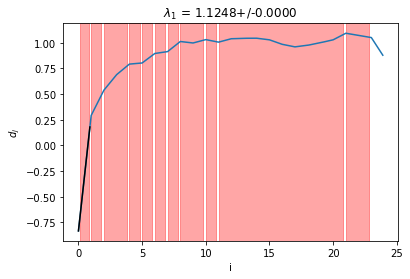

computed in  23.61573 s
Expected time remaining =  1189.808961857143 s

211 ) Computing  Thu 31 Oct 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


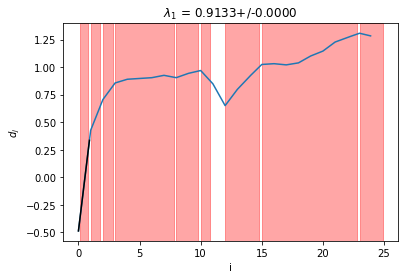

computed in  25.985643000000003 s
Expected time remaining =  1161.8037159526066 s

212 ) Computing  Fri 01 Nov 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


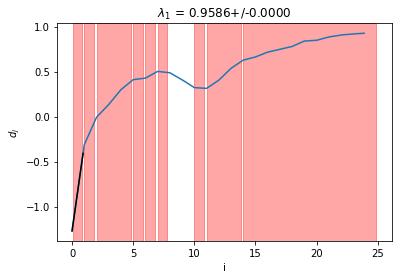

computed in  27.332886000000002 s
Expected time remaining =  1134.0780746179246 s

213 ) Computing  Mon 04 Nov 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


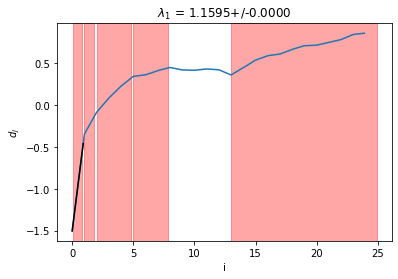

computed in  26.59148 s
Expected time remaining =  1106.2168899530518 s

214 ) Computing  Tue 05 Nov 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


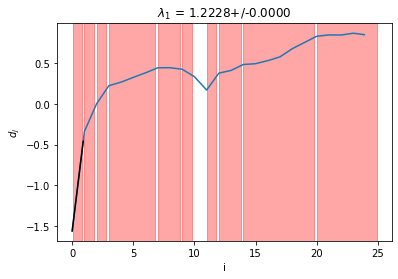

computed in  27.226911 s
Expected time remaining =  1078.4833745327105 s

215 ) Computing  Wed 06 Nov 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


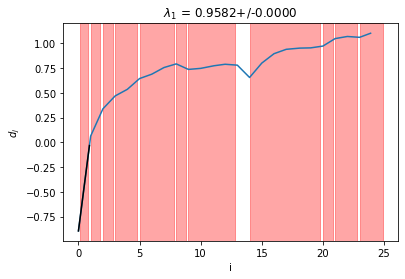

computed in  25.757634000000003 s
Expected time remaining =  1050.4948855441862 s

216 ) Computing  Thu 07 Nov 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


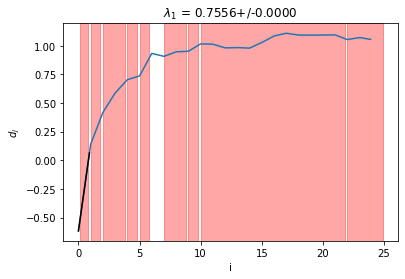

computed in  23.110053 s
Expected time remaining =  1022.073531800926 s

217 ) Computing  Fri 08 Nov 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


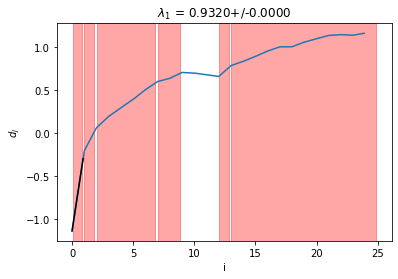

computed in  27.14158 s
Expected time remaining =  994.3699548940093 s

218 ) Computing  Mon 11 Nov 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


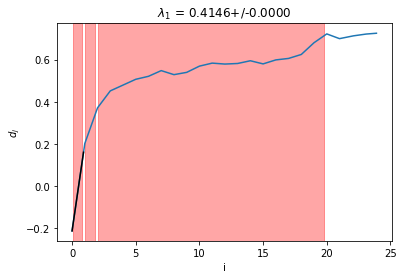

computed in  23.535382000000002 s
Expected time remaining =  966.0925571788993 s

219 ) Computing  Tue 12 Nov 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


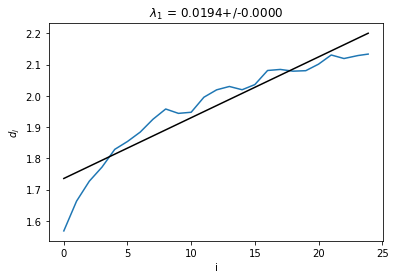

computed in  20.508831 s
Expected time remaining =  937.3885900456622 s

220 ) Computing  Wed 13 Nov 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


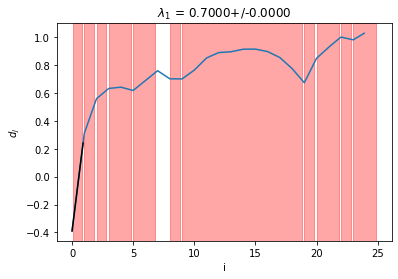

computed in  25.397225000000006 s
Expected time remaining =  909.4923832500002 s

221 ) Computing  Thu 14 Nov 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


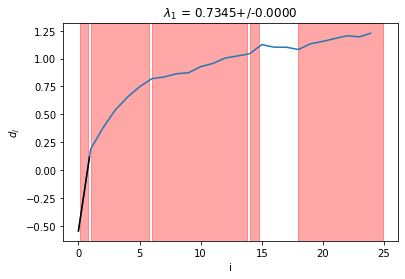

computed in  24.88268 s
Expected time remaining =  881.5442874208146 s

222 ) Computing  Fri 15 Nov 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


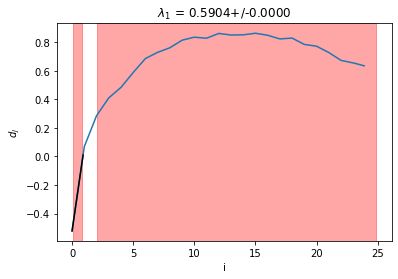

computed in  24.543926 s
Expected time remaining =  853.576504463964 s

223 ) Computing  Mon 18 Nov 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


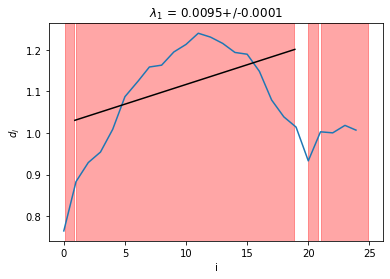

computed in  21.663685 s
Expected time remaining =  825.2519523766817 s

224 ) Computing  Tue 19 Nov 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


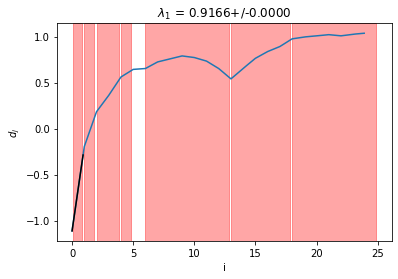

computed in  26.494874 s
Expected time remaining =  797.61233875 s

225 ) Computing  Wed 20 Nov 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


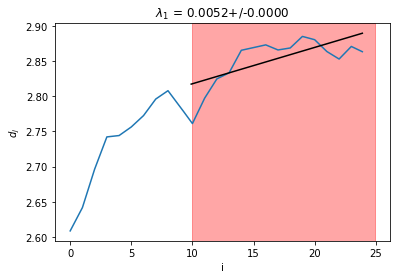

computed in  20.404493000000002 s
Expected time remaining =  769.2249865066667 s

226 ) Computing  Thu 21 Nov 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


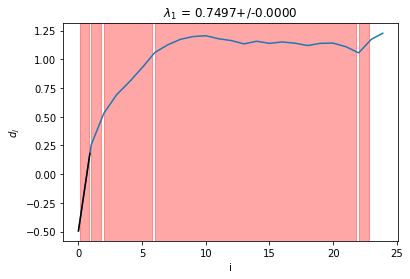

computed in  24.805917 s
Expected time remaining =  741.4341128761062 s

227 ) Computing  Fri 22 Nov 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


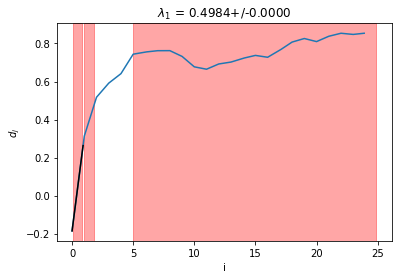

computed in  23.670659999999998 s
Expected time remaining =  713.5395089867842 s

228 ) Computing  Mon 25 Nov 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


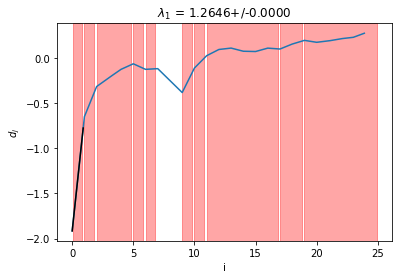

computed in  28.793997000000005 s
Expected time remaining =  686.2437266447369 s

229 ) Computing  Tue 26 Nov 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


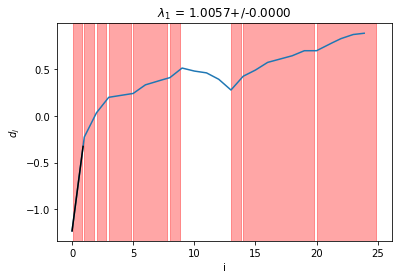

computed in  27.064619 s
Expected time remaining =  658.7536146026202 s

230 ) Computing  Wed 27 Nov 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


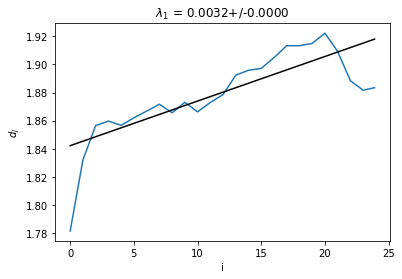

computed in  19.02777 s
Expected time remaining =  630.4635176000002 s

231 ) Computing  Fri 29 Nov 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


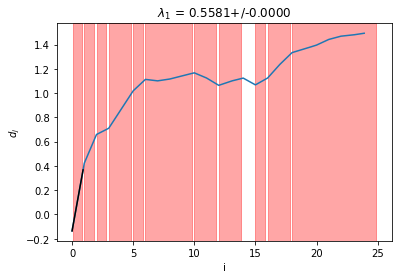

computed in  7.8318780000000014 s
Expected time remaining =  601.1873384761905 s

232 ) Computing  Mon 02 Dec 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


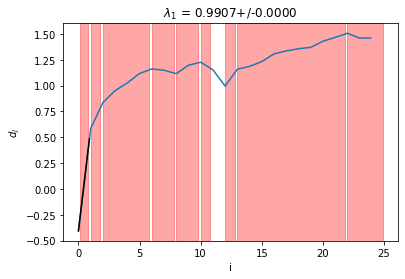

computed in  27.249883000000004 s
Expected time remaining =  573.853688262931 s

233 ) Computing  Tue 03 Dec 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


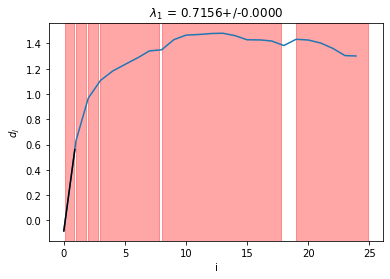

computed in  24.505754 s
Expected time remaining =  546.285209527897 s

234 ) Computing  Wed 04 Dec 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


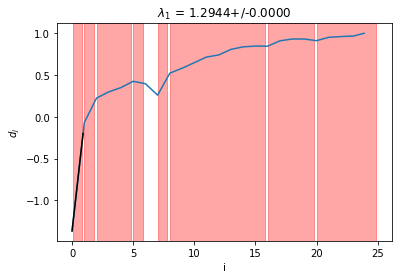

computed in  27.95831 s
Expected time remaining =  519.0232436709401 s

235 ) Computing  Thu 05 Dec 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


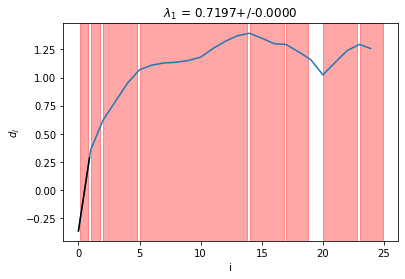

computed in  24.332899000000005 s
Expected time remaining =  491.4776604255319 s

236 ) Computing  Fri 06 Dec 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


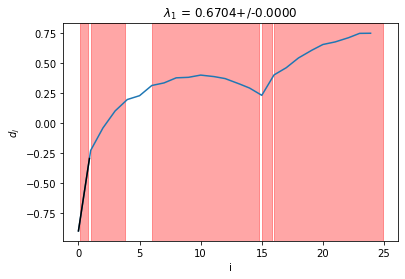

computed in  26.673629000000002 s
Expected time remaining =  464.1279152245762 s

237 ) Computing  Mon 09 Dec 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


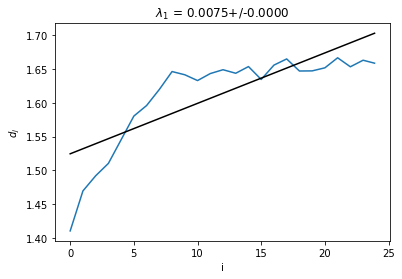

computed in  21.107607 s
Expected time remaining =  436.40811044725734 s

238 ) Computing  Tue 10 Dec 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


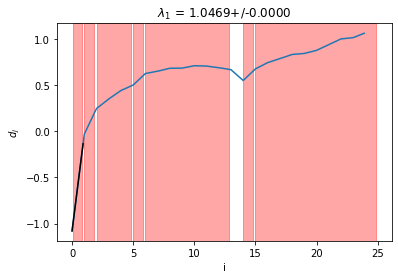

computed in  26.123506 s
Expected time remaining =  409.05999844537814 s

239 ) Computing  Wed 11 Dec 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


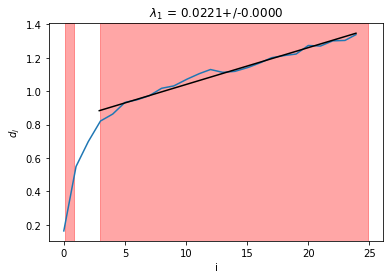

computed in  23.757375000000003 s
Expected time remaining =  381.58353237656905 s

240 ) Computing  Thu 12 Dec 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


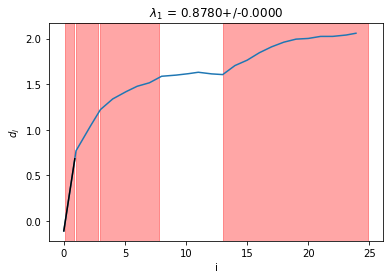

computed in  26.895559000000002 s
Expected time remaining =  354.3080437000001 s

241 ) Computing  Fri 13 Dec 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


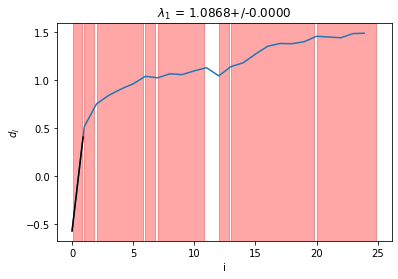

computed in  26.48568 s
Expected time remaining =  327.01529905394193 s

242 ) Computing  Mon 16 Dec 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


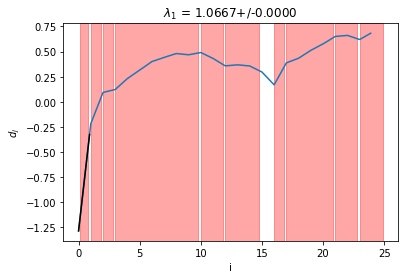

computed in  26.351139000000003 s
Expected time remaining =  299.7231088636364 s

243 ) Computing  Tue 17 Dec 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


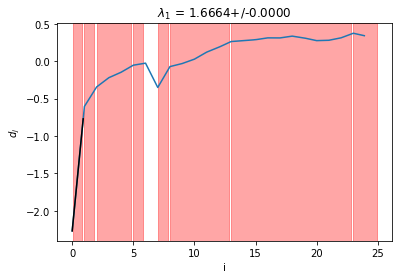

computed in  28.664783 s
Expected time remaining =  272.5338756378601 s

244 ) Computing  Wed 18 Dec 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


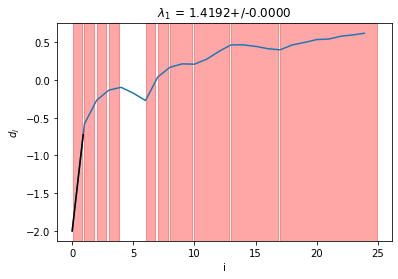

computed in  28.437778 s
Expected time remaining =  245.32417460655742 s

245 ) Computing  Thu 19 Dec 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


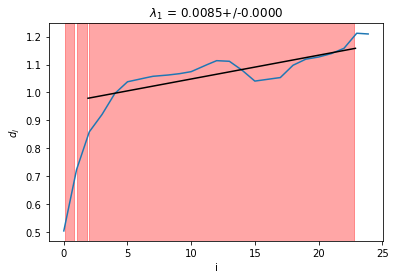

computed in  22.200955 s
Expected time remaining =  217.90079709387757 s

246 ) Computing  Fri 20 Dec 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


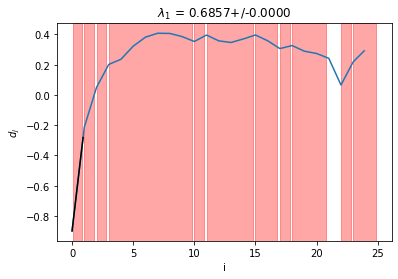

computed in  24.439596 s
Expected time remaining =  190.5835794674797 s

247 ) Computing  Mon 23 Dec 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


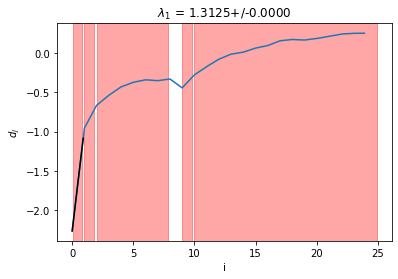

computed in  27.313100000000002 s
Expected time remaining =  163.35946413765186 s

248 ) Computing  Tue 24 Dec 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


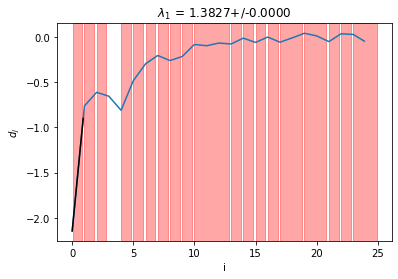

computed in  9.442674 s
Expected time remaining =  135.77434034274194 s

249 ) Computing  Thu 26 Dec 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


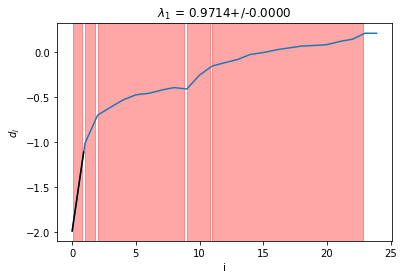

computed in  28.239891000000004 s
Expected time remaining =  108.63690236144579 s

250 ) Computing  Fri 27 Dec 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


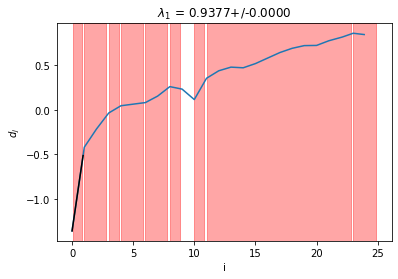

computed in  27.211688000000002 s
Expected time remaining =  81.47830632 s

251 ) Computing  Mon 30 Dec 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


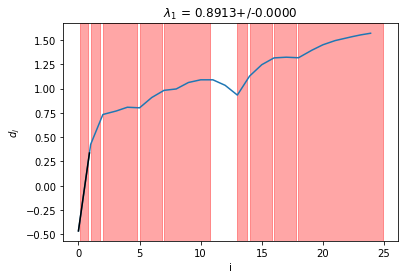

computed in  27.167126000000003 s
Expected time remaining =  54.318932159362554 s

252 ) Computing  Tue 31 Dec 2019 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


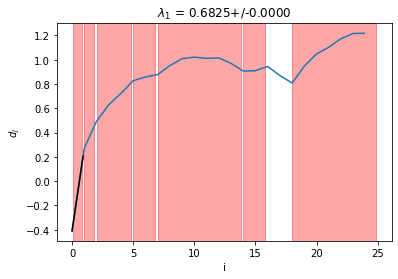

computed in  25.995213000000003 s
Expected time remaining =  27.15484602777778 s

253 ) Computing  Thu 02 Jan 2020 ... 

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


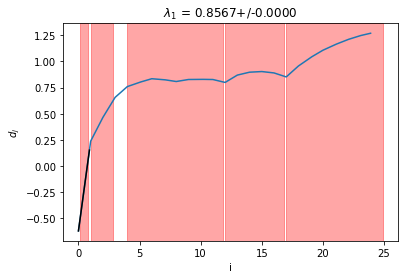

computed in  24.99508 s
Expected time remaining =  0.0 s
computation time =  6868.819799


DATE  lyapunov_exponent         error  compute time
0   2019-01-02       4.053220e-04  4.625929e-20     24.071721
1   2019-01-03       7.268681e-04  3.854941e-20     27.155641
2   2019-01-04       4.030577e-04  1.079383e-19     24.337035
3   2019-01-07       1.988916e-04  1.696174e-19     21.294056
4   2019-01-08       4.044788e-04  3.083953e-20     23.024150
5   2019-01-09       7.779774e-04  7.324388e-20     25.873171
6   2019-01-10       2.645596e-04  5.396917e-20     24.330980
7   2019-01-11       5.300714e-04  1.156482e-20     24.939361
8   2019-01-14       7.964782e-04  7.709882e-20     26.934327
9   2019-01-15       6.277340e-04  3.083953e-20     26.526133
10  2019-01-16       8.885239e-04  6.167906e-20     26.786772
11  2019-01-17       3.093340e-04  4.625929e-20     25.449244
12  2019-01-18       2.856300e-04  6.167906e-20     22.234889
13  2019-01-22       7.358850e-06  1.035192e-05     20.126257
14  2019-01-23       1.081820e-05  1.602430e-05     20.853106
15  2019-01-24       6.224932e-04  2.505712e-20     24.919027
16  2019-01-25       9.238508e-04  1.156482e-19     26.800037
17  2019-01-28       7.632382e-04  0.000000e+00     25.334157
18  2019-01-29       6.286191e-04  4.625929e-20     25.929761
19  2019-01-30       7.156950e-06  1.112728e-05     20.873496
20  2019-01-31       4.415405e-04  3.565820e-20     26.089296
21  2019-02-01       5.216719e-04  1.541976e-20     24.136113
22  2019-02-04       3.977335e-06  2.161910e-05     21.121429
23  2019-02-05       5.556650e-04  3.662194e-20     23.971915
24  2019-02-06       8.685046e-04  9.251859e-20     27.189496
25  2019-02-07       2.476987e-04  2.158767e-19     22.293522
26  2019-02-08       2.752303e-04  1.541976e-19     20.878971
27  2019-02-11       9.605428e-04  3.854941e-20     27.488742
28  2019-02-12       1.373238e-05  2.882842e-05     22.765276
29  2019-02-13       2.579843e-04  2.120218e-20     24.818922
30  2019-02-14       2.330126e-04  4.625929e-20     22.260603
31  2019-02-15       1.169556e-03  1.541976e-19     28.379627
32  2019-02-19       4.885291e-06  1.677447e-05     22.313854
33  2019-02-20       9.528996e-04  3.854941e-20     27.411289
34  2019-02-21       3.368269e-04  1.002285e-19     23.071811
35  2019-02-22       4.134234e-04  3.662194e-20     25.559482
36  2019-02-25       2.295713e-04  3.083953e-20     21.844441
37  2019-02-26       7.397176e-04  3.083953e-20     26.372634
38  2019-02-27       1.277284e-04  3.083953e-20     20.580318
39  2019-02-28       7.439063e-04  6.938894e-20     26.567216
40  2019-03-01       2.980322e-04  0.000000e+00     30.830930
41  2019-03-04      -2.335420e-06  6.593848e-06     23.088329
42  2019-03-05       9.899932e-04  3.854941e-20     36.230146
43  2019-03-06       4.758224e-04  4.336809e-20     31.199771
44  2019-03-07       5.749151e-04  5.011423e-20     35.366151
45  2019-03-08       9.399925e-04  2.390063e-19     35.208764
46  2019-03-11       1.568593e-06  2.611138e-05     28.239542
47  2019-03-12       8.582385e-04  6.938894e-20     34.675286
48  2019-03-13      -4.591459e-06  7.915768e-06     28.715927
49  2019-03-14       7.746253e-04  8.480870e-20     35.343519
50  2019-03-15       5.945586e-06  1.433120e-05     25.891582
51  2019-03-18       6.405965e-04  0.000000e+00     34.876310
52  2019-03-19       6.545940e-04  6.360653e-20     31.701925
53  2019-03-20       2.720227e-04  3.083953e-20     29.834237
54  2019-03-21       1.034939e-05  8.330665e-06     27.145313
55  2019-03-22       2.728125e-04  1.541976e-19     31.012213
56  2019-03-25       8.011606e-04  8.480870e-20     34.853073
57  2019-03-26       1.334233e-05  4.075802e-05     25.198690
58  2019-03-27       7.196142e-06  1.815324e-05     27.547751
59  2019-03-28       2.866612e-04  1.541976e-20     31.389115
60  2019-03-29       8.791325e-04  7.709882e-20     35.960660
61  2019-04-01       4.566688e-04  2.216591e-20     30.058584
62  2019-04-02       9.412957e-04  8.480870e-20     36.328646
63  2019-04-03       2.356193e-05  2.02459

In [425]:
calculate_lyapunov_exponents(SandP_1mins,start, end, plot_fit = True, plot_derivatives= False, m = 2) 

# Example
### Example - converting into phase space

In [13]:
test = SandP_1mins.loc[SandP_1mins['DATE'] == '2019-02-01']['OPEN']

In [14]:
test_matrix = gen_phase_space_matrix(test, J = 5, m =2 )
test_matrix = test_matrix.dropna()  ## drop rows that are missing a phase space co-ord (due to lag taking past end of list)
test_matrix

0        1
0    2702.32  2705.31
1    2704.99  2706.47
2    2706.17  2706.52
3    2704.86  2705.75
4    2705.05  2705.44
5    2705.31  2707.54
6    2706.47  2709.28
7    2706.52  2709.45
8    2705.75  2708.86
9    2705.44  2707.36
10   2707.54  2707.81
11   2709.28  2709.56
12   2709.45  2707.16
13   2708.86  2708.28
14   2707.36  2706.72
15   2707.81  2704.42
16   2709.56  2702.99
17   2707.16  2702.46
18   2708.28  2703.63
19   2706.72  2702.71
20   2704.42  2704.30
21   2702.99  2704.65
22   2702.46  2703.10
23   2703.63  2702.41
24   2702.71  2700.79
25   2704.30  2700.23
26   2704.65  2704.80
27   2703.10  2702.22
28   2702.41  2703.73
29   2700.79  2707.02
30   2700.23  2709.34
31   2704.80  2712.14
32   2702.22  2711.76
33   2703.73  2710.65
34   2707.02  2711.36
35   2709.34  2711.82
36   2712.14  2712.27
37   2711.76  2712.61
38   2710.65  2713.18
39   2711.36  2712.38
40   2711.82  2712.48
41   2712.27  2712.27
42   2712.61  2712.15
43   2713.18  2714.21
44   2712.38  2713.39
45   2712.48  2713.19
46   2712.27  2713.77
47   2712.15  2713.91
48   2714.21  2715.55
49   2713.39  2715.42
50   2713.19  2716.24
51   2713.77  2716.42
52   2713.91  2716.03
53   2715.55  2715.96
54   2715.42  2716.36
55   2716.24  2714.89
56   2716.42  2713.30
57   2716.03  2712.28
58   2715.96  2713.38
59   2716.36  2714.67
60   2714.89  2713.46
61   2713.30  2713.52
62   2712.28  2714.11
63   2713.38  2714.45
64   2714.67  2713.59
65   2713.46  2714.16
66   2713.52  2714.90
67   2714.11  2715.84
68   2714.45  2715.11
69   2713.59  2714.60
70   2714.16  2713.49
71   2714.90  2714.04
72   2715.84  2712.64
73   2715.11  2713.11
74   2714.60  2712.55
75   2713.49  2712.12
76   2714.04  2712.27
77   2712.64  2710.56
78   2713.11  2710.45
79   2712.55  2709.59
80   2712.12  2708.71
81   2712.27  2708.32
82   2710.56  2707.32
83   2710.45  2707.71
84   2709.59  2708.24
85   2708.71  2706.59
86   2708.32  2706.45
87   2707.32  2704.05
88   2707.71  2705.09
89   2708.24  2706.11
90   2706.59  2706.69
91   2706.45  2708.10
92   2704.05  2708.50
93   2705.09  2707.90
94   2706.11  2709.38
95   2706.69  2708.99
96   2708.10  2709.56
97   2708.50  2708.37
98   2707.90  2709.01
99   2709.38  2708.43
100  2708.99  2709.42
101  2709.56  2709.32
102  2708.37  2710.58
103  2709.01  2709.57
104  2708.43  2709.37
105  2709.42  2708.17
106  2709.32  2708.23
107  2710.58  2709.96
108  2709.57  2711.16
109  2709.37  2710.53
110  2708.17  2710.31
111  2708.23  2711.34
112  2709.96  2710.69
113  2711.16  2711.30
114  2710.53  2711.48
115  2710.31  2710.53
116  2711.34  2709.83
117  2710.69  2710.61
118  2711.30  2709.96
119  2711.48  2710.14
120  2710.53  2710.01
121  2709.83  2710.34
122  2710.61  2711.04
123  2709.96  2710.25
124  2710.14  2710.55
125  2710.01  2710.17
126  2710.34  2711.41
127  2711.04  2711.10
128  2710.25  2711.90
129  2710.55  2712.00
130  2710.17  2712.36
131  2711.41  2712.12
132  2711.10  2711.50
133  2711.90  2710.28
134  2712.00  2712.00
135  2712.36  2712.52
136  2712.12  2712.90
137  2711.50  2713.10
138  2710.28  2712.99
139  2712.00  2713.69
140  2712.52  2714.02
141  2712.90  2714.01
142  2713.10  2714.93
143  2712.99  2714.62
144  2713.69  2714.37
145  2714.02  2714.63
146  2714.01  2714.12
147  2714.93  2713.32
148  2714.62  2713.24
149  2714.37  2713.91
150  2714.63  2713.29
151  2714.12  2713.14
152  2713.32  2713.80
153  2713.24  2713.48
154  2713.91  2712.97
155  2713.29  2712.58
156  2713.14  2713.07
157  2713.80  2712.03
158  2713.48  2712.52
159  2712.97  2712.46
160  2712.58  2711.83
161  2713.07  2711.69
162  2712.03  2711.53
163  2712.52  2711.99
164  2712.46  2710.97
165  2711.83  2710.63
166  2711.69  2709.71
167  2711.53  2709.39
168  2711.99  2708.05
169  2710.97  2708.22
170  2710.63  2707.01
171  2709.71  2706.89
172  2709.39  2707.14
173  2708.05  2707.13
174  2708.22  2707.40
175  2707.01  2707.93
176  2706.89  2707.23
177  2707.14  2707.09
178  2707.13  2708.18
179  2707.40  2707.78
180  2707.93  2707.71
181  27

### Example - find nearest neighbour 

In [17]:
mu = compute_mean_period(test)

90.65208415691983

In [18]:
find_nearest_neighbour(test_matrix,80,mu)

219

In [63]:
test_matrix.iloc[0]

0    2702.32
1    2705.31
Name: 0, dtype: float64

In [64]:
test_matrix.iloc[363]

0    2702.97
1    2704.70
Name: 363, dtype: float64

In [21]:
### find nearest neighbour pairs
NN_pairs = []        
mu = compute_mean_period(test)


for i in range(0,test_matrix.shape[0]):
    NN = find_nearest_neighbour(test_matrix, ref_index= i, mean_period = mu, i_max = 25)
    NN_pairs.append([i,NN])
    
print(NN_pairs)

[[0, 363], [1, 232], [2, 264], [3, 258], [4, 258], [5, 235], [6, 181], [7, 181], [8, 191], [9, 235], [10, 189], [11, 103], [12, 172], [13, 221], [14, 225], [15, 251], [16, 252], [17, 269], [18, 252], [19, 269], [20, 266], [21, 363], [22, 308], [23, 272], [24, 286], [25, 317], [26, 266], [27, 273], [28, 361], [29, 363], [30, 233], [31, 181], [32, 190], [33, 191], [34, 214], [35, 128], [36, 134], [37, 136], [38, 138], [39, 131], [40, 134], [41, 135], [42, 163], [43, 141], [44, 139], [45, 136], [46, 139], [47, 139], [48, 145], [49, 142], [50, 142], [51, 142], [52, 145], [53, 145], [54, 145], [55, 147], [56, 147], [57, 148], [58, 150], [59, 150], [60, 151], [61, 153], [62, 153], [63, 156], [64, 158], [65, 156], [66, 158], [67, 158], [68, 159], [69, 163], [70, 161], [71, 163], [72, 163], [73, 164], [74, 165], [75, 166], [76, 167], [77, 168], [78, 169], [79, 170], [80, 219], [81, 219], [82, 219], [83, 219], [84, 219], [85, 186], [86, 223], [87, 252], [88, 253], [89, 226], [90, 264], [91, 237

### Example - calc divergence

In [23]:
test_div = compute_divergence(test_matrix, NN_pairs)

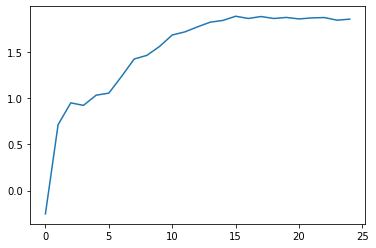

In [24]:
plot = pd.DataFrame(test_div, columns = ['i', 'ln(dj)'])
plt.plot(plot['i'], plot['ln(dj)'])

# Compare to fractional data - fit first bit 


# Effect of different m values?


In [32]:
start = '2019-01-02'
end = '2020-01-02'


embedding dimension =  1
computing for  1 days
Start at  2020-03-29 13:20:06.567024


1 ) Computing  Wed 02 Jan 2019 ... 

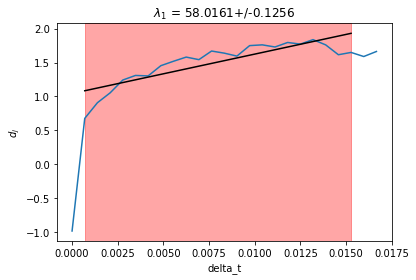

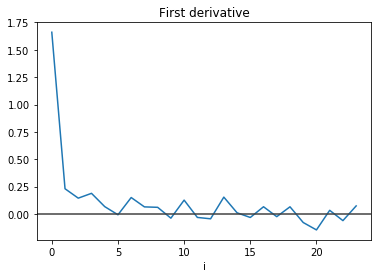

Standard deviation =  0.31126164588466193


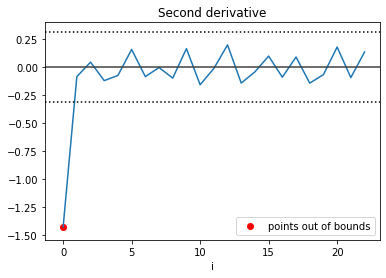

computed in  28.017405000000004 s
Expected time remaining =  0.0 s
computation time =  28.020518

embedding dimension =  2
computing for  1 days
Start at  2020-03-29 13:20:34.593065


1 ) Computing  Wed 02 Jan 2019 ... 

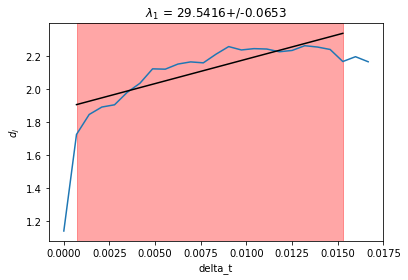

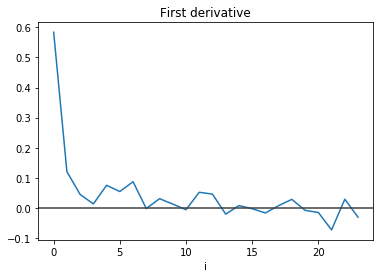

Standard deviation =  0.10392588704619898


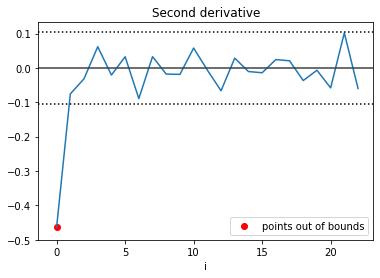

computed in  24.890379 s
Expected time remaining =  0.0 s
computation time =  24.893685

embedding dimension =  3
computing for  1 days
Start at  2020-03-29 13:20:59.493088


1 ) Computing  Wed 02 Jan 2019 ... 

/Users/calumthompson/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


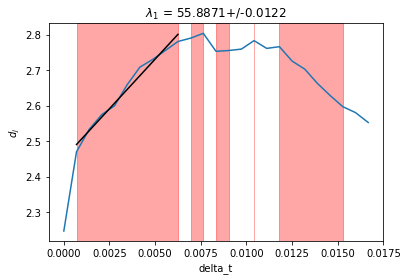

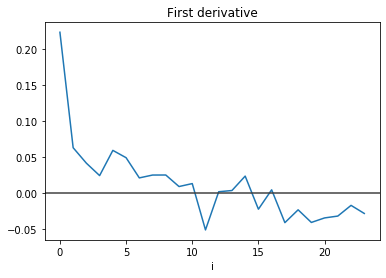

Standard deviation =  0.041295528065176695


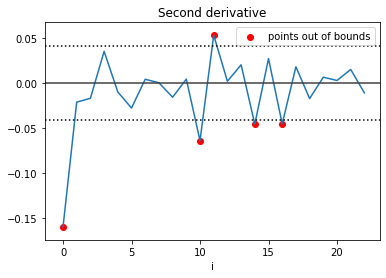

computed in  20.935512000000003 s
Expected time remaining =  0.0 s
computation time =  20.938721

embedding dimension =  4
computing for  1 days
Start at  2020-03-29 13:21:20.437371


1 ) Computing  Wed 02 Jan 2019 ... 

/Users/calumthompson/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calumthompson/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


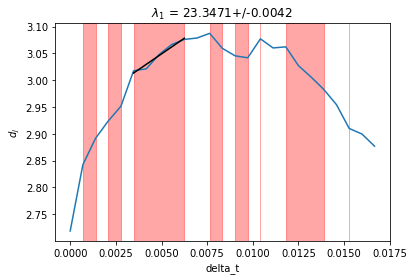

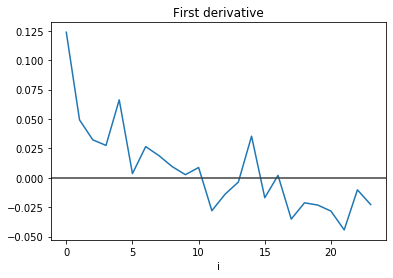

Standard deviation =  0.029897589980556912


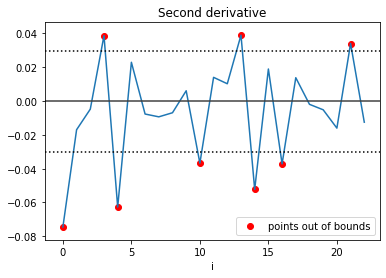

computed in  19.003679 s
Expected time remaining =  0.0 s
computation time =  19.006589


In [43]:
m_results = []
for m in range(1,5):
    print("")
    print("embedding dimension = ", m )
    result = calculate_lyapunov_exponents(SandP_1mins,start, end, plot_fit = True, plot_derivatives= True, m = m)
    m_results.append([m,result['lyapunov_exponent'][0]])

In [42]:
pd.DataFrame(m_results,columns = ['m', 'lyapunov exponent'])

m  lyapunov exponent
0  1          58.016071
1  2          29.541616
2  3          55.887058
3  4          23.347143

In [110]:
results = pd.read_csv('2019-01-02 to 2020-01-02_m2.csv')
results['DATE'] = pd.to_datetime(results['DATE'])

In [111]:
comparison = close_prices.loc[(close_prices['DATE'] >= start) & (close_prices['DATE'] <= end)]

In [112]:
plot_data = pd.merge(comparison, results)

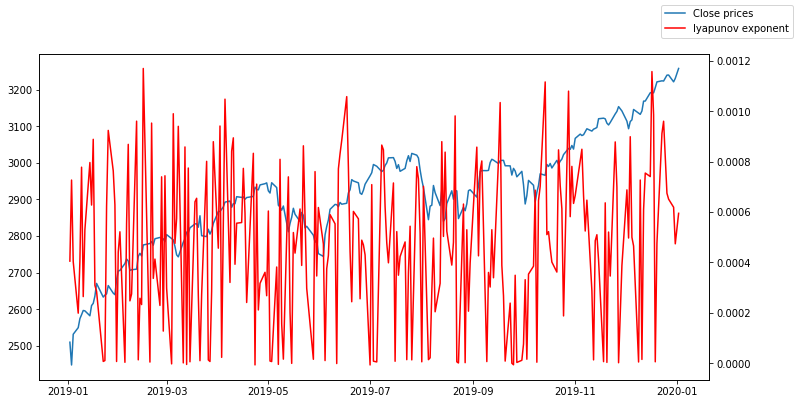

In [113]:
fig, ax1 = plt.subplots(figsize = [12,6])

ax1.plot( plot_data['DATE'],plot_data['OPEN'], label = 'Close prices')
ax2 = ax1.twinx()

ax2.plot(plot_data['DATE'] ,plot_data['lyapunov_exponent'], label = 'lyapunov exponent', c = 'r')
fig.legend()
plt.show();


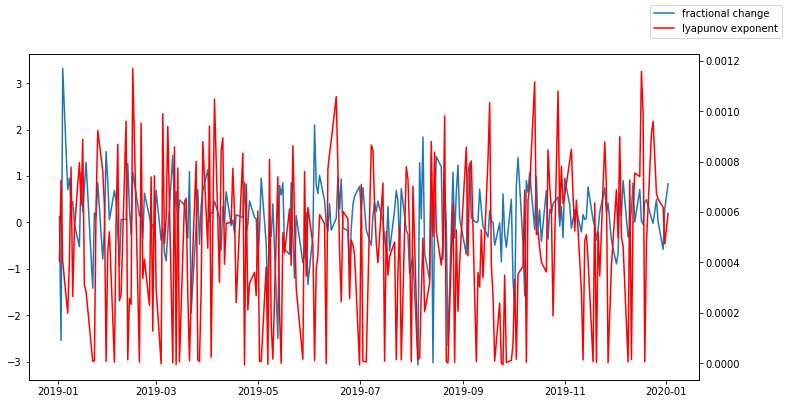

In [114]:
fig, ax1 = plt.subplots(figsize = [12,6])

ax1.plot( plot_data['DATE'],plot_data['Change %'], label = 'fractional change')
ax2 = ax1.twinx()

ax2.plot(plot_data['DATE'] ,plot_data['lyapunov_exponent'], label = 'lyapunov exponent', c = 'r')
fig.legend()
plt.show();


In [121]:
near_zero = plot_data.loc[np.abs(plot_data['lyapunov_exponent']) < 0.00001]

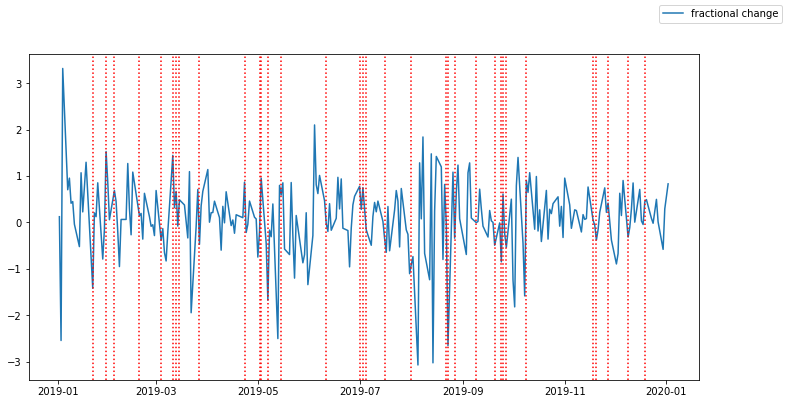

In [122]:
fig, ax1 = plt.subplots(figsize = [12,6])

plt.plot( plot_data['DATE'],plot_data['Change %'], label = 'fractional change')

for i in range(0,near_zero.shape[0]):
    zero_date = near_zero.iloc[i]['DATE']
    plt.axvline(zero_date, linestyle = ':', c = 'r')

#ax2 = ax1.twinx()

#ax2.plot(near_zero['DATE'] ,near_zero['lyapunov_exponent'], label = 'lyapunov exponent', c = 'r', linestyle = 'None', marker = 'o')
fig.legend()
plt.show();

# Compare to fractional data - last years gradient score



gradient  -0.0013695796131028295
r squared  0.0013832151144490545
gradient  0.5579104665483653


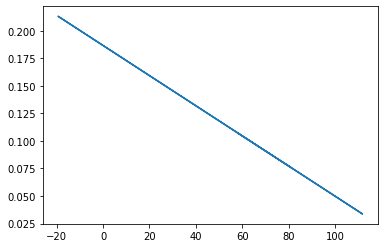

In [60]:
regressor = LinearRegression() 
regressor.fit(x,y)
fit = regressor.predict(x) 

slope = regressor.coef_[0][0]
error = metrics.mean_absolute_error(y, fit)  
r_squared = metrics.r2_score(y,fit)

plt.plot(x,fit)

print("gradient ", slope)
print("r squared ", r_squared)
print("gradient ", error)

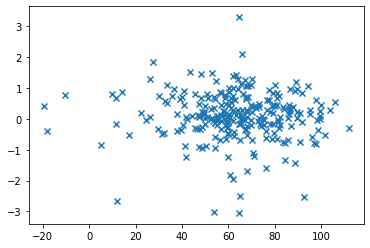

In [59]:
x = plot_data['lyapunov_exponent'].values.reshape(-1, 1)
y = plot_data['Change %'].values.reshape(-1, 1)
error = plot_data['error']
plt.scatter(x, y, marker = 'x')

In [54]:
results = pd.read_csv('2019-01-02 to 2020-01-02_m1.csv')
results['DATE'] = pd.to_datetime(results['DATE'])

In [55]:
comparison = close_prices.loc[(close_prices['DATE'] >= start) & (close_prices['DATE'] <= end)]

In [56]:
plot_data = pd.merge(comparison, results)
plot_data

DATE     OPEN  Change %  lyapunov_exponent     error
0   2019-01-02  2509.98  0.123905          58.016071  0.125552
1   2019-01-03  2447.77 -2.541497          92.720395  0.077450
2   2019-01-04  2531.72  3.315928          64.763039  0.066380
3   2019-01-07  2549.69  0.704792          40.006668  0.060767
4   2019-01-08  2574.26  0.954449          86.358534  0.093349
5   2019-01-09  2584.97  0.414318          78.625907  0.123347
6   2019-01-10  2596.64  0.449427          99.888063  0.100236
7   2019-01-11  2595.65 -0.038141          75.479601  0.144081
8   2019-01-14  2582.22 -0.520095          67.904230  0.077351
9   2019-01-15  2610.15  1.070053          67.450060  0.106611
10  2019-01-16  2616.10  0.227438          70.273616  0.128320
11  2019-01-17  2635.95  0.753049          81.612916  0.099791
12  2019-01-18  2670.57  1.296352          26.255159  0.086512
13  2019-01-22  2633.27 -1.416490          88.576884  0.019517
14  2019-01-23  2638.71  0.206161          22.228547  0.096230
15  2019-01-24  2642.01  0.124905          56.896134  0.177911
16  2019-01-25  2664.76  0.853735          56.943705  0.131307
17  2019-01-28  2643.93 -0.787842          84.202350  0.086231
18  2019-01-29  2639.93 -0.151519          79.101356  0.121550
19  2019-01-30  2680.87  1.527116          43.505818  0.019858
20  2019-01-31  2704.49  0.873362          56.457987  0.087593
21  2019-02-01  2706.08  0.058757          82.028310  0.153230
22  2019-02-04  2724.83  0.688116          11.429013  0.025930
23  2019-02-05  2737.21  0.452285          60.038109  0.141368
24  2019-02-06  2731.78 -0.198771          75.368884  0.130114
25  2019-02-07  2706.08 -0.949713          48.462563  0.113448
26  2019-02-08  2707.83  0.064627          47.107692  0.060597
27  2019-02-11  2709.60  0.065323          41.868163  0.151157
28  2019-02-12  2744.44  1.269476          67.336831  0.056363
29  2019-02-13  2752.85  0.305502          84.139351  0.144740
30  2019-02-14  2745.56 -0.265520          48.786743  0.042795
31  2019-02-15  2775.66  1.084427          69.564158  0.136747
32  2019-02-19  2779.65  0.143543          37.716476  0.052468
33  2019-02-20  2785.06  0.194251          79.111372  0.119354
34  2019-02-21  2775.11 -0.358544          98.664517  0.123265
35  2019-02-22  2792.63  0.627366          77.402716  0.167325
36  2019-02-25  2796.14  0.125530          46.993217  0.109863
37  2019-02-26  2793.83 -0.082682          62.020443  0.185525
38  2019-02-27  2792.45 -0.049419          81.501570  0.126983
39  2019-02-28  2784.58 -0.282628          81.869743  0.129051
40  2019-03-01  2803.86  0.687623          60.957881  0.100667
41  2019-03-04  2793.21 -0.381282         -17.979211  0.002516
42  2019-03-05  2789.55 -0.131204          59.987652  0.157239
43  2019-03-06  2771.56 -0.649093          78.749081  0.118917
44  2019-03-07  2748.77 -0.829098          97.859956  0.180920
45  2019-03-08  2743.07 -0.207796          69.903787  0.100745
46  2019-03-11  2783.28  1.444698          48.060049  0.062034
47  2019-03-12  2792.16  0.318033          52.535894  0.078779
48  2019-03-13  2810.92  0.667397          48.162885  0.073637
49  2019-03-14  2808.71 -0.078684          56.957994  0.138278
50  2019-03-15  2822.48  0.487869          47.447403  0.035444
51  2019-03-18  2833.14  0.376261          87.694887  0.095834
52  2019-03-19  2833.55  0.014469          73.221183  0.107361
53  2019-03-20  2824.14 -0.333199          29.500601  0.119407
54  2019-03-21  2855.40  1.094768          33.686636  0.047563
55  2019-03-22  2800.95 -1.943983          61.841158  0.102991
56  2019-03-25  2798.51 -0.087189          91.680864  0.115096
57  2019-03-26  2818.54  0.710652          53.576235  0.090358
58  2019-03-27  2805.34 -0.470531          32.301881  0.045386
59  2019-03-28  2815.40  0.357320          86.311569  0.084119
60  2019-03-29  2834.40  0.670336          58.398904  0.119940
61  2019-04-01  2867.06  1.139146          65.217877  0.094399
62  2019-04-02  2867.22  0.005580        

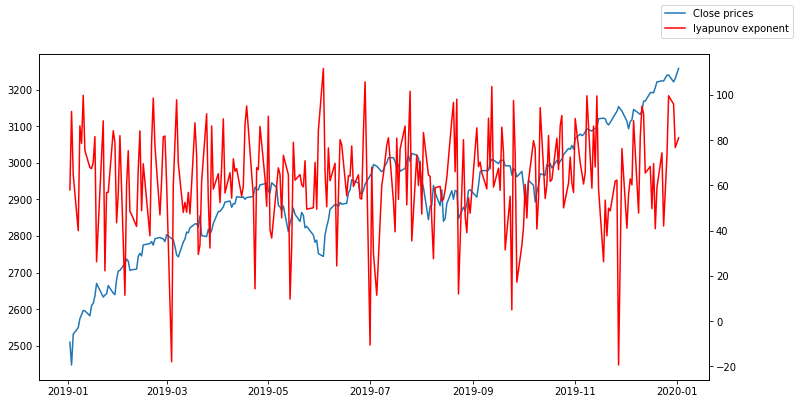

In [57]:
fig, ax1 = plt.subplots(figsize = [12,6])

ax1.plot( plot_data['DATE'],plot_data['OPEN'], label = 'Close prices')
ax2 = ax1.twinx()

ax2.plot(plot_data['DATE'] ,plot_data['lyapunov_exponent'], label = 'lyapunov exponent', c = 'r')
fig.legend()
plt.show();


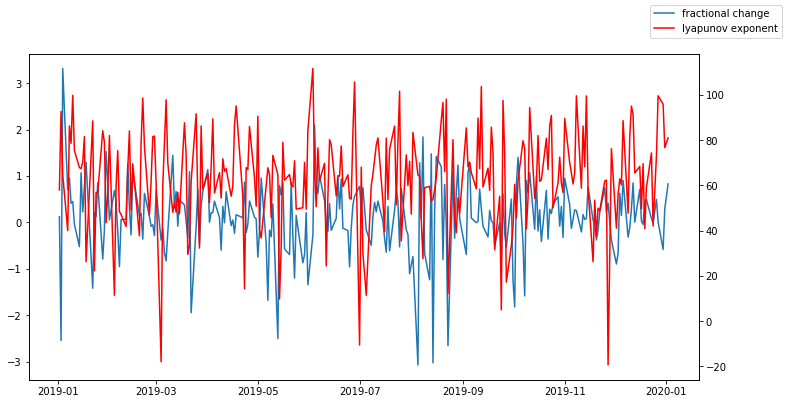

In [58]:
fig, ax1 = plt.subplots(figsize = [12,6])

ax1.plot( plot_data['DATE'],plot_data['Change %'], label = 'fractional change')
ax2 = ax1.twinx()

ax2.plot(plot_data['DATE'] ,plot_data['lyapunov_exponent'], label = 'lyapunov exponent', c = 'r')
fig.legend()
plt.show();


In [99]:
# x = ['lyapunov_exponent']
# y = plot_data['Change %']
# error = plot_data['error']
# plt.scatter(x, y, marker = 'x')
# plt.xlim(-0.0025,0.0025)

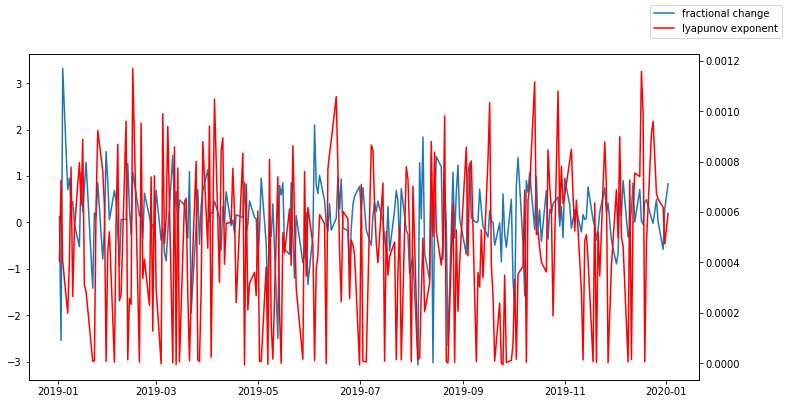

In [109]:
fig, ax1 = plt.subplots(figsize = [12,6])

ax1.plot( plot_data['DATE'],plot_data['Change %'], label = 'fractional change')
ax2 = ax1.twinx()

ax2.plot(plot_data['DATE'] ,plot_data['lyapunov_exponent'], label = 'lyapunov exponent', c = 'r')
fig.legend()
plt.show();
